In [1]:
from qiskit import QuantumCircuit
from qiskit.converters import circuit_to_dag
from qiskit.dagcircuit import DAGOpNode
from circuit_analysis import find_qubit_reuse_pairs, modify_circuit, last_index_operation, first_index_operation
import stim
import sys

def apply_caqr(qc: QuantumCircuit):
    cur_qc = qc.copy()
    reuse_pairs = find_qubit_reuse_pairs(cur_qc)
    iter_count = 0
    chain = []
    weight = (1, 1, 1)


    while len(reuse_pairs) > 0 and iter_count < len(qc.qubits) - 1:
        depth_diff = sys.maxsize    
        lst_index = last_index_operation(cur_qc)
        fst_index = first_index_operation(cur_qc)
        
        for i in range(len(reuse_pairs)):
            test_qc = cur_qc.copy()
            test_out_qc = modify_circuit(test_qc, reuse_pairs[i])

            if weight[0]*(test_out_qc.depth() - cur_qc.depth()) + weight[1]* lst_index[reuse_pairs[i][0]]+weight[2]*abs(lst_index[reuse_pairs[i][0]] - fst_index[reuse_pairs[i][1]]) < depth_diff:
                depth_diff = test_out_qc.depth() - cur_qc.depth() + 0.5*lst_index[reuse_pairs[i][0]]
                best_pair = reuse_pairs[i]

        chain.append((best_pair[0], best_pair[1]))
        modified_qc = modify_circuit(cur_qc, best_pair)

        reuse_pairs = find_qubit_reuse_pairs(modified_qc)
        cur_qc = modified_qc.copy()
        iter_count += 1
        lst_index = last_index_operation(cur_qc)

    return cur_qc, iter_count, chain

In [ ]:
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

def test_bv_circuit(qc, secret_string, circuit_name="Circuit"):
    test_qc = qc.copy()

    simulator = AerSimulator()
    job = simulator.run(test_qc, shots=1000)
    result = job.result()
    counts = result.get_counts()
    
    print(f"\n--- Testing {circuit_name} ---")
    print(f"Expected secret string: {secret_string}")
    print(f"Measurement results:")
    
    most_common = max(counts, key=counts.get)
    
    n = len(secret_string)
    
    for key, count in sorted(counts.items(), key=lambda x: x[1], reverse=True)[:5]:
        measured_bits = key[-n:] if len(key) >= n else key
        percentage = 100 * count / 1000
        match = "✓" if measured_bits == secret_string else "✗"
        print(f"  {measured_bits}: {count:4d} ({percentage:5.1f}%) {match}")
    
    result_bits = most_common[-n:] if len(most_common) >= n else most_common
    is_correct = result_bits == secret_string
    
    if is_correct:
        print(f"SUCCESS: Circuit correctly identifies secret string!")
    else:
        print(f"FAILED: Got {result_bits}, expected {secret_string}")
    
    display(plot_histogram(counts))
    
    return is_correct

In [ ]:
from qiskit import QuantumCircuit

def qubit_segment_lifetimes(qc: QuantumCircuit):
    n_qubits = qc.num_qubits

    qubit_index = {qb: i for i, qb in enumerate(qc.qubits)}
    segment_start = [None] * n_qubits
    last_nonreset_t = [None] * n_qubits
    segments_per_qubit = [[] for _ in range(n_qubits)]

    for t, inst in enumerate(qc.data):
        op = getattr(inst, "operation", getattr(inst, "op", None))
        op_name = getattr(op, "name", "") if op is not None else ""

        qargs = [qubit_index[qb] for qb in inst.qubits]

        if op_name == "reset":
            for qi in qargs:
                if segment_start[qi] is not None and last_nonreset_t[qi] is not None:
                    if last_nonreset_t[qi] >= segment_start[qi]:
                        length = last_nonreset_t[qi] - segment_start[qi] + 1
                        if length > 0:
                            segments_per_qubit[qi].append(length)
                segment_start[qi] = None
                last_nonreset_t[qi] = None
        else:
            for qi in qargs:
                if segment_start[qi] is None:
                    segment_start[qi] = t
                last_nonreset_t[qi] = t

    for qi in range(n_qubits):
        if segment_start[qi] is not None and last_nonreset_t[qi] is not None:
            if last_nonreset_t[qi] >= segment_start[qi]:
                length = last_nonreset_t[qi] - segment_start[qi] + 1
                if length > 0:
                    segments_per_qubit[qi].append(length)

    return segments_per_qubit


def summarise_segment_lifetimes(qc: QuantumCircuit, name: str):
    segments_per_qubit = qubit_segment_lifetimes(qc)
    all_segments = [seg for segs in segments_per_qubit for seg in segs]

    total_len = sum(all_segments)
    n_segments = len(all_segments)

    if n_segments > 0:
        max_seg = max(all_segments)
        avg_seg = total_len / n_segments
    else:
        max_seg = 0
        avg_seg = 0.0

    print(f"\n--- {name} ---")
    for i, segs in enumerate(segments_per_qubit):
        print(f"Qubit {i}: segments {segs}")
    print(f"Total #segments:      {n_segments}")
    print(f"Total segment length: {total_len}")
    print(f"Max segment length:   {max_seg}")
    print(f"Avg segment length:   {avg_seg:.2f}")
    if avg_seg > 0:
        print(f"Max/Avg (pre-reset) ratio: {max_seg / avg_seg:.2f}")

    return segments_per_qubit, all_segments

In [ ]:
import stim
from qiskit import QuantumCircuit

def qiskit_to_stim_circuit_with_noise(
    qc: QuantumCircuit,
    p1: float = 0.0,
    p2: float = 0.0,
) -> stim.Circuit:
    single_qubit_gate_map = {
        "h": "H",
        "x": "X",
        "y": "Y",
        "z": "Z",
        "s": "S",
        "sdg": "S_DAG",
        "sx": "SQRT_X",
        "measure": "MR",
        "reset": "R",
    }

    stim_circuit = stim.Circuit()

    for gate in qc:
        op_name = gate.operation.name.lower()
        qubit = qc.find_bit(gate.qubits[0])[0]

        if op_name in single_qubit_gate_map:
            stim_op = single_qubit_gate_map[op_name]
            stim_circuit.append(stim_op, [qubit])

            if p1 > 0 and op_name not in ["measure", "reset"]:
                stim_circuit.append("DEPOLARIZE1", [qubit], p1)

        elif op_name == "cx":
            target = qc.find_bit(gate.qubits[1])[0]
            stim_circuit.append("CX", [qubit, target])

            if p2 > 0:
                stim_circuit.append("DEPOLARIZE2", [qubit, target], p2)

        elif op_name == "barrier":
            stim_circuit.append("TICK")

        else:
            raise ValueError(f"Unsupported gate: {op_name}")

    return stim_circuit

In [ ]:
import numpy as np

def run_bv_on_stim(
    qc: QuantumCircuit,
    secret_string: str,
    p1: float = 0.0,
    p2: float = 0.0,
    shots: int = 20_000,
    label: str = "BV on Stim",
) -> float:   
    n = len(secret_string)

    stim_circuit = qiskit_to_stim_circuit_with_noise(qc, p1=p1, p2=p2)

    # Build measurement -> classical-bit mapping
    #    meas_map[k] = classical_bit_index that Stim measurement k writes to
    meas_map = []
    meas_counter = 0

    clbit_index = {cb: idx for idx, cb in enumerate(qc.clbits)}

    for gate in qc:
        op_name = gate.operation.name.lower()
        if op_name == "measure":
            cbit = gate.clbits[0]
            c_idx = clbit_index[cbit]
            meas_map.append((meas_counter, c_idx))
            meas_counter += 1

    num_meas_stim = stim_circuit.num_measurements
    if num_meas_stim != meas_counter:
        print(f"WARNING: Qiskit saw {meas_counter} measures, Stim has {num_meas_stim}.")

    sampler = stim_circuit.compile_sampler()
    samples = sampler.sample(shots)

    # Reconstruct Qiskit-style bitstrings for the BV bits
    counts = {}

    for shot in samples:
        cvals = [0] * n

        for meas_idx, c_idx in meas_map:
            if c_idx < n:
                cvals[c_idx] = int(shot[meas_idx])

        bits = []
        for c_idx in range(n - 1, -1, -1):
            bits.append(str(cvals[c_idx]))
        bitstring = ''.join(bits)
        
        counts[bitstring] = counts.get(bitstring, 0) + 1

    success_prob = counts.get(secret_string, 0) / shots
    return success_prob


In [6]:
import pymatching

def estimate_pL_surface_code(distance: int,
                             rounds: int = 10,
                             p_phys: float = 1e-3,
                             shots: int = 50_000) -> float:
    circuit = stim.Circuit.generated(
        "surface_code:rotated_memory_x",
        distance=distance,
        rounds=rounds,
        after_clifford_depolarization=p_phys,
    )

    dem = circuit.detector_error_model(decompose_errors=True)
    matching = pymatching.Matching.from_detector_error_model(dem)

    sampler = circuit.compile_detector_sampler()
    syndromes, observables = sampler.sample(
        shots=shots,
        separate_observables=True,
    )

    predicted = matching.decode_batch(syndromes)
    failures = np.sum(np.any(predicted != observables, axis=1))
    p_fail_total = failures / shots
    p_L = p_fail_total / rounds
    return p_L

In [7]:
import stim

def phys_qubits_per_logical(distance: int) -> int:
    circ = stim.Circuit.generated(
        "surface_code:rotated_memory_x",
        distance=distance,
        rounds=1,
        after_clifford_depolarization=0.0,
    )
    return circ.num_qubits


In [ ]:
from qiskit import QuantumCircuit

def spacetime_volume_for_circuit(
    qc: QuantumCircuit,
    distance: int,
    rounds_per_logical_layer: int | None = None,
) -> int:
    n_logical = qc.num_qubits
    depth = qc.depth()

    if rounds_per_logical_layer is None:
        rounds_per_logical_layer = distance

    Q_phys = phys_qubits_per_logical(distance) * n_logical
    T_cycles = depth * rounds_per_logical_layer

    return Q_phys * T_cycles


Estimating logical error rate for d=5...
Logical error rate p_L ≈ 7.5920e-03


Testing BV with n=3 (secret string: 111)
CAQR: Reused 2 qubits
Chain: [(0, 1), (0, 2)]
Max/Avg lifetime ratio: 2.15
Fidelity - Original: 0.9268, CAQR: 0.9339

Testing BV with n=4 (secret string: 1111)
CAQR: Reused 3 qubits
Chain: [(0, 1), (0, 2), (0, 3)]
Max/Avg lifetime ratio: 2.71
Fidelity - Original: 0.9042, CAQR: 0.9105

Testing BV with n=5 (secret string: 11111)
CAQR: Reused 4 qubits
Chain: [(0, 1), (0, 2), (0, 3), (0, 4)]
Max/Avg lifetime ratio: 3.27
Fidelity - Original: 0.8873, CAQR: 0.8919

Testing BV with n=6 (secret string: 111111)
CAQR: Reused 5 qubits
Chain: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]
Max/Avg lifetime ratio: 3.83
Fidelity - Original: 0.8757, CAQR: 0.8698

Testing BV with n=7 (secret string: 1111111)
CAQR: Reused 6 qubits
Chain: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6)]
Max/Avg lifetime ratio: 4.39
Fidelity - Original: 0.8491, CAQR: 0.8489

Testing BV with n=8 (secret string: 

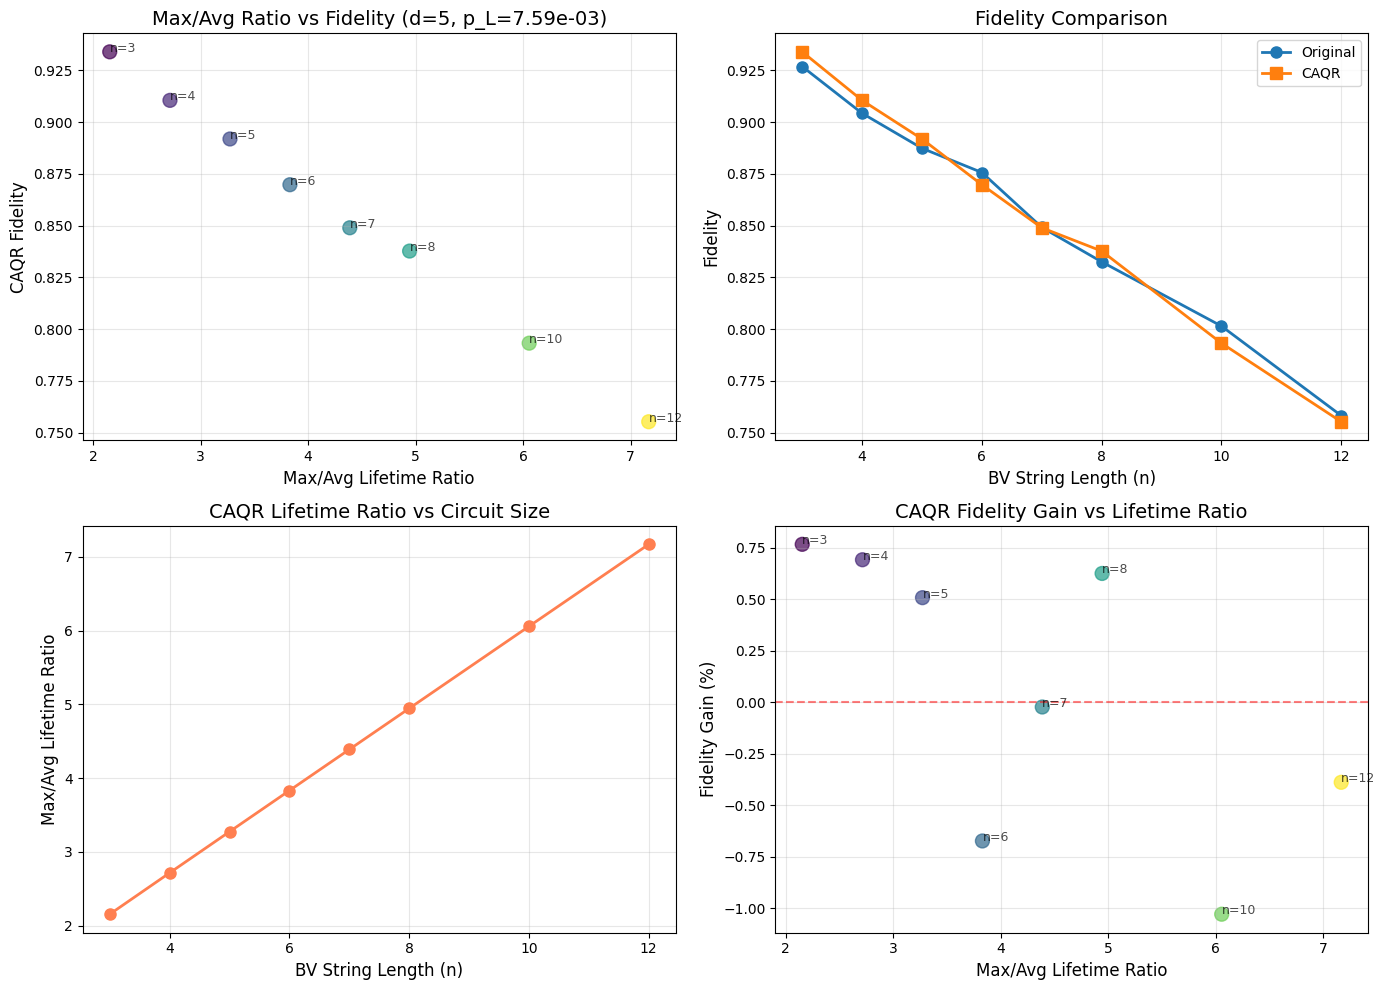


SUMMARY TABLE
  n |  Reuses |  Ratio |  F_orig |  F_caqr |  Gain(%) | D_orig | D_caqr
--------------------------------------------------------------------------------
  3 |       2 |   2.15 |  0.9268 |  0.9339 |     0.77 |      7 |     15
  4 |       3 |   2.71 |  0.9042 |  0.9105 |     0.69 |      8 |     20
  5 |       4 |   3.27 |  0.8873 |  0.8919 |     0.51 |      9 |     25
  6 |       5 |   3.83 |  0.8757 |  0.8698 |    -0.67 |     10 |     30
  7 |       6 |   4.39 |  0.8491 |  0.8489 |    -0.02 |     11 |     35
  8 |       7 |   4.94 |  0.8325 |  0.8377 |     0.62 |     12 |     40
 10 |       9 |   6.06 |  0.8014 |  0.7932 |    -1.03 |     14 |     50
 12 |      11 |   7.17 |  0.7582 |  0.7552 |    -0.39 |     16 |     60


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def analyze_caqr_vs_lifetime_ratio(
    string_lengths: list,
    distance: int = 5,
    rounds: int = 10,
    p_phys_surface: float = 1e-2,
    shots_pL: int = 50_000,
    shots_bv: int = 20_000,
):
    results = []
    
    print(f"Estimating logical error rate for d={distance}...")
    pL = estimate_pL_surface_code(
        distance=distance,
        rounds=rounds,
        p_phys=p_phys_surface,
        shots=shots_pL
    )
    print(f"Logical error rate p_L ≈ {pL:.4e}\n")
    
    for n in string_lengths:
        print(f"\n{'='*60}")
        print(f"Testing BV with n={n} (secret string: {'1'*n})")
        print('='*60)
        
        # Create BV circuit with all 1s
        s = '1' * n
        qc_seq = QuantumCircuit(n + 1, n)
        
        qc_seq.x(n)
        qc_seq.h(n)
        
        for i in range(n):
            qc_seq.h(i)
            if s[n - 1 - i] == '1':
                qc_seq.cx(i, n)
            qc_seq.h(i)
        
        for i in range(n):
            qc_seq.measure(i, i)
        
        cur_qc, iter_count, chain = apply_caqr(qc_seq)
        
        print(f"CAQR: Reused {iter_count} qubits")
        print(f"Chain: {chain}")
        
        segments_orig = qubit_segment_lifetimes(qc_seq)
        segments_caqr = qubit_segment_lifetimes(cur_qc)
        
        all_segs_caqr = [seg for segs in segments_caqr for seg in segs]
        if len(all_segs_caqr) > 0:
            max_seg = max(all_segs_caqr)
            avg_seg = sum(all_segs_caqr) / len(all_segs_caqr)
            max_avg_ratio = max_seg / avg_seg if avg_seg > 0 else 0
        else:
            max_avg_ratio = 0
        
        print(f"Max/Avg lifetime ratio: {max_avg_ratio:.2f}")
        
        p1 = pL
        p2 = 2 * pL
        
        fidelity_orig = run_bv_on_stim(qc_seq, s, p1=p1, p2=p2, shots=shots_bv, 
                                       label=f"Original n={n}")
        fidelity_caqr = run_bv_on_stim(cur_qc, s, p1=p1, p2=p2, shots=shots_bv,
                                       label=f"CAQR n={n}")
        
        print(f"Fidelity - Original: {fidelity_orig:.4f}, CAQR: {fidelity_caqr:.4f}")
        
        results.append({
            'n': n,
            'num_reuses': iter_count,
            'max_avg_ratio': max_avg_ratio,
            'fidelity_orig': fidelity_orig,
            'fidelity_caqr': fidelity_caqr,
            'depth_orig': qc_seq.depth(),
            'depth_caqr': cur_qc.depth(),
        })
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    ratios = [r['max_avg_ratio'] for r in results]
    fidelities_orig = [r['fidelity_orig'] for r in results]
    fidelities_caqr = [r['fidelity_caqr'] for r in results]
    ns = [r['n'] for r in results]
    
    axes[0, 0].scatter(ratios, fidelities_caqr, s=100, alpha=0.7, c=ns, cmap='viridis')
    axes[0, 0].set_xlabel('Max/Avg Lifetime Ratio', fontsize=12)
    axes[0, 0].set_ylabel('CAQR Fidelity', fontsize=12)
    axes[0, 0].set_title(f'Max/Avg Ratio vs Fidelity (d={distance}, p_L={pL:.2e})', fontsize=14)
    axes[0, 0].grid(True, alpha=0.3)
    
    for i, r in enumerate(results):
        axes[0, 0].annotate(f"n={r['n']}", (ratios[i], fidelities_caqr[i]), 
                           fontsize=9, alpha=0.7)
    
    axes[0, 1].plot(ns, fidelities_orig, 'o-', label='Original', linewidth=2, markersize=8)
    axes[0, 1].plot(ns, fidelities_caqr, 's-', label='CAQR', linewidth=2, markersize=8)
    axes[0, 1].set_xlabel('BV String Length (n)', fontsize=12)
    axes[0, 1].set_ylabel('Fidelity', fontsize=12)
    axes[0, 1].set_title('Fidelity Comparison', fontsize=14)
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    axes[1, 0].plot(ns, ratios, 'o-', linewidth=2, markersize=8, color='coral')
    axes[1, 0].set_xlabel('BV String Length (n)', fontsize=12)
    axes[1, 0].set_ylabel('Max/Avg Lifetime Ratio', fontsize=12)
    axes[1, 0].set_title('CAQR Lifetime Ratio vs Circuit Size', fontsize=14)
    axes[1, 0].grid(True, alpha=0.3)
    
    fidelity_gains = [(fidelities_caqr[i] / fidelities_orig[i] - 1) * 100 
                     if fidelities_orig[i] > 0 else 0 
                     for i in range(len(results))]
    axes[1, 1].scatter(ratios, fidelity_gains, s=100, alpha=0.7, c=ns, cmap='viridis')
    axes[1, 1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
    axes[1, 1].set_xlabel('Max/Avg Lifetime Ratio', fontsize=12)
    axes[1, 1].set_ylabel('Fidelity Gain (%)', fontsize=12)
    axes[1, 1].set_title('CAQR Fidelity Gain vs Lifetime Ratio', fontsize=14)
    axes[1, 1].grid(True, alpha=0.3)
    
    for i, r in enumerate(results):
        axes[1, 1].annotate(f"n={r['n']}", (ratios[i], fidelity_gains[i]), 
                           fontsize=9, alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*80)
    print("SUMMARY TABLE")
    print("="*80)
    print(f"{'n':>3} | {'Reuses':>7} | {'Ratio':>6} | {'F_orig':>7} | {'F_caqr':>7} | {'Gain(%)':>8} | {'D_orig':>6} | {'D_caqr':>6}")
    print("-"*80)
    for i, r in enumerate(results):
        gain = (fidelities_caqr[i] / fidelities_orig[i] - 1) * 100 if fidelities_orig[i] > 0 else 0
        print(f"{r['n']:3d} | {r['num_reuses']:7d} | {r['max_avg_ratio']:6.2f} | "
              f"{r['fidelity_orig']:7.4f} | {r['fidelity_caqr']:7.4f} | {gain:8.2f} | "
              f"{r['depth_orig']:6d} | {r['depth_caqr']:6d}")
    
    return results

string_lengths = [3, 4, 5, 6, 7, 8, 10, 12]  # Different BV string lengths
results = analyze_caqr_vs_lifetime_ratio(
    string_lengths=string_lengths,
    distance=5,
    rounds=10,
    p_phys_surface=1e-2,
    shots_pL=50_000,
    shots_bv=20_000,
)

In [10]:
def build_bv_circuit(secret_string: str) -> QuantumCircuit:
    n = len(secret_string)
    qc = QuantumCircuit(n + 1, n)

    qc.x(n)
    qc.h(n)

    for i in range(n):
        qc.h(i)
        if secret_string[n - 1 - i] == '1':
            qc.cx(i, n)
        qc.h(i)

    for i in range(n):
        qc.measure(i, i)

    return qc

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

def build_xor_n_circuit(input_bits: str) -> QuantumCircuit:
    n = len(input_bits)
    assert n >= 1

    q = QuantumRegister(n + 1, "q")
    c_out = ClassicalRegister(1, "out")
    qc = QuantumCircuit(q, c_out)

    for i, b in enumerate(input_bits):
        if b == "1":
            qc.x(q[i])

    for i in range(n):
        qc.cx(q[i], q[n])

    qc.measure(q[n], c_out[0])

    return qc


def xor_parity(input_bits: str) -> str:
    return str(sum(int(b) for b in input_bits) % 2)



--- Original XOR_5 Circuit ---


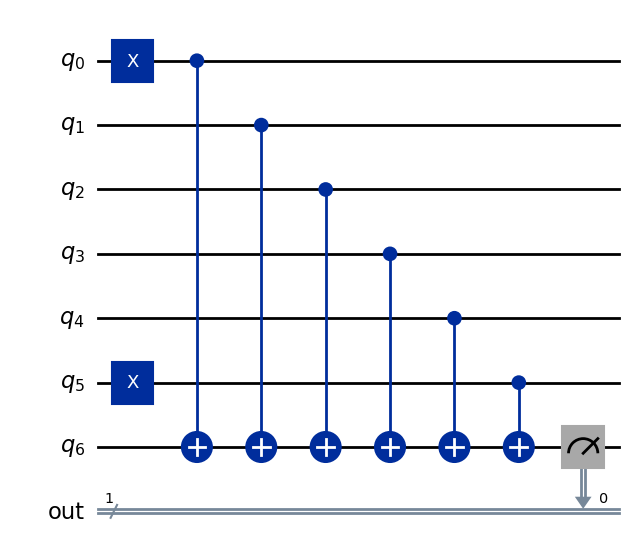


--- XOR_5 after CaQR ---


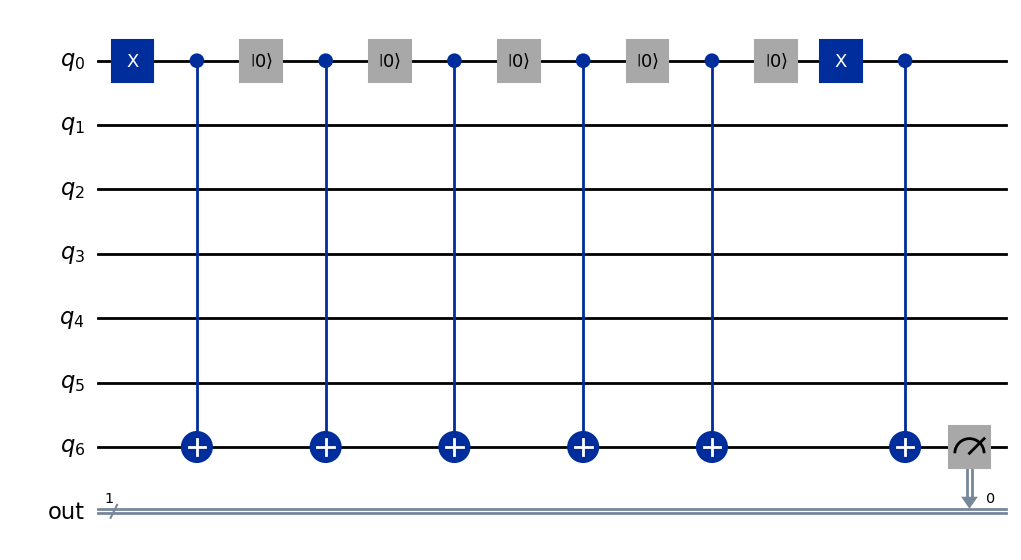

Reused 5 qubit(s)
Reuse chain (XOR_5): [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]

--- Testing XOR_5 original ---
Input bits: 100001
Expected XOR parity: 0
Top outcomes:
  0: 2000 (100.0%) ✓
SUCCESS most common = 0

--- Testing XOR_5 after CaQR ---
Input bits: 100001
Expected XOR parity: 0
Top outcomes:
  0: 2000 (100.0%) ✓
SUCCESS most common = 0


True

In [ ]:
from qiskit_aer import AerSimulator

# run caqr on it
def test_xor_n_circuit(qc, input_bits: str, circuit_name="XOR_n"):
    secret = xor_parity(input_bits)
    sim = AerSimulator()
    job = sim.run(qc, shots=2000)
    counts = job.result().get_counts()

    print(f"\n--- Testing {circuit_name} ---")
    print(f"Input bits: {input_bits}")
    print(f"Expected XOR parity: {secret}")
    print("Top outcomes:")

    for bitstring, count in sorted(counts.items(), key=lambda x: x[1], reverse=True)[:5]:
        pct = 100 * count / 2000
        # single output bit is c_out[0] -> last char
        match = "✓" if bitstring[-1] == secret else "✗"
        print(f"  {bitstring}: {count:4d} ({pct:5.1f}%) {match}")

    most_common = max(counts, key=counts.get)
    success = (most_common[-1] == secret)
    print("SUCCESS" if success else "FAIL", "most common =", most_common[-1])
    return success

xor_input = "100001"
qc_xor = build_xor_n_circuit(xor_input)
print("\n--- Original XOR_5 Circuit ---")
display(qc_xor.draw("mpl"))
qc_xor_caqr, xor_iter_count, xor_chain = apply_caqr(qc_xor)
print(f"\n--- XOR_5 after CaQR ---")
display(qc_xor_caqr.draw("mpl"))
print(f"Reused {xor_iter_count} qubit(s)")
print("Reuse chain (XOR_5):", xor_chain)
test_xor_n_circuit(qc_xor, xor_input, "XOR_5 original")
test_xor_n_circuit(qc_xor_caqr, xor_input, "XOR_5 after CaQR")



ANALYZING BV CIRCUITS

Testing BV with n=3
CAQR: Reused 2 qubits, Chain: [(0, 1), (0, 2)]
Max/Avg lifetime ratio: 2.15
  Testing d=3 (original)... F=0.9154
  Testing d=3 (CAQR)... F=0.9400
✓ Min distance: Original=3, CAQR=3

Testing BV with n=4
CAQR: Reused 3 qubits, Chain: [(0, 1), (0, 2), (0, 3)]
Max/Avg lifetime ratio: 2.71
  Testing d=3 (original)... F=0.8948
  Testing d=5 (original)... F=0.9137
  Testing d=3 (CAQR)... F=0.9218
✓ Min distance: Original=5, CAQR=3

Testing BV with n=5
CAQR: Reused 4 qubits, Chain: [(0, 1), (0, 2), (0, 3), (0, 4)]
Max/Avg lifetime ratio: 3.27
  Testing d=3 (original)... F=0.8731
  Testing d=5 (original)... F=0.8920
  Testing d=7 (original)... F=0.9135
  Testing d=3 (CAQR)... F=0.9039
✓ Min distance: Original=7, CAQR=3

Testing BV with n=6
CAQR: Reused 5 qubits, Chain: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]
Max/Avg lifetime ratio: 3.83
  Testing d=3 (original)... F=0.8535
  Testing d=5 (original)... F=0.8688
  Testing d=7 (original)... F=0.8976
  Te

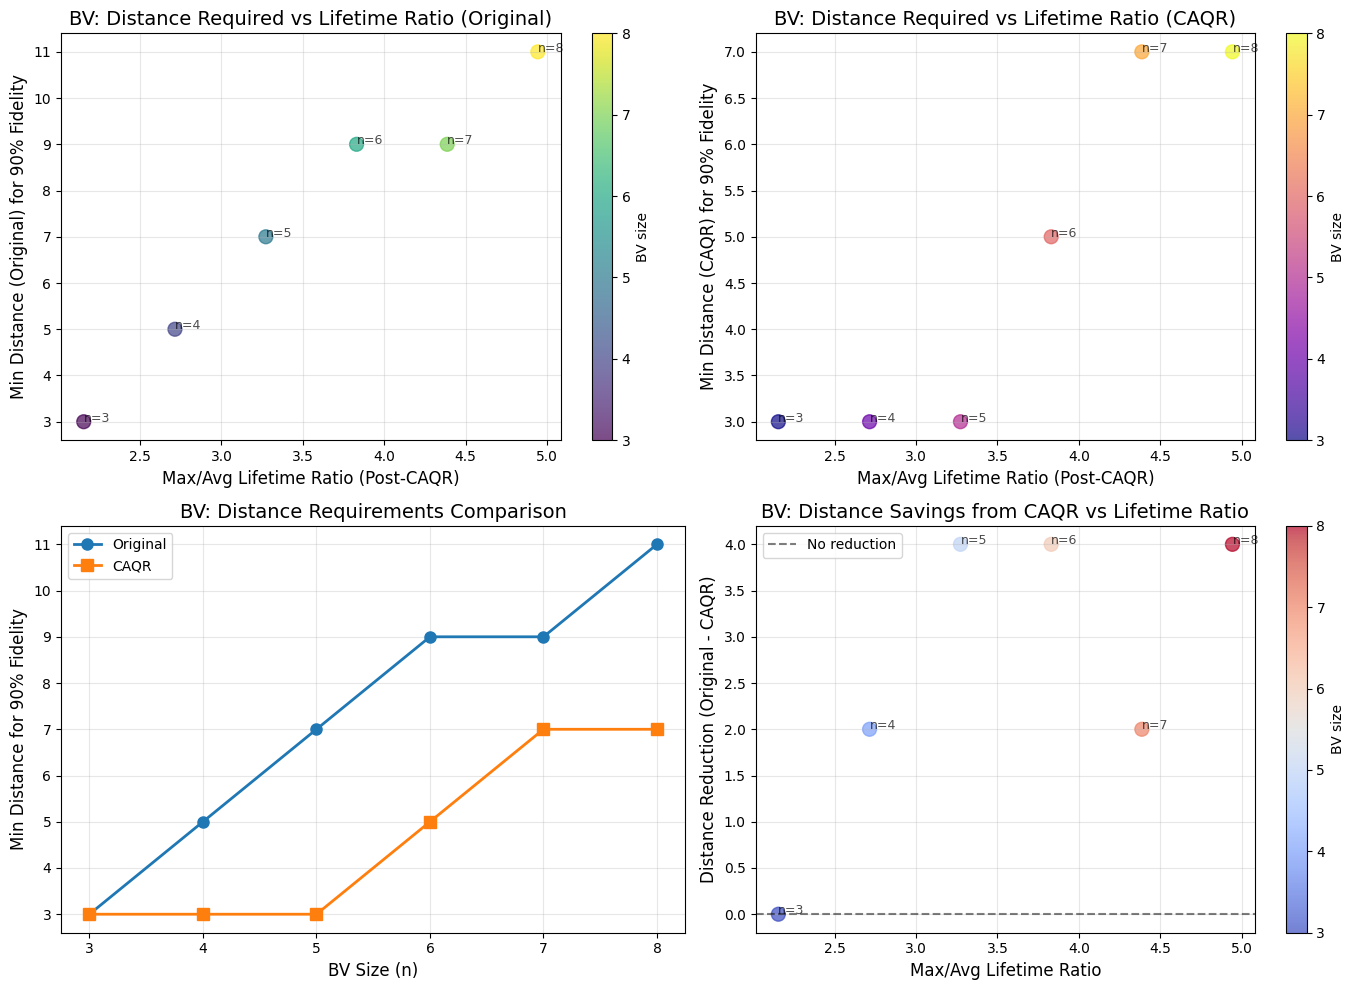


BV DISTANCE REQUIREMENTS FOR 90% FIDELITY
  n |  Reuses |  Ratio |  d_orig |  d_caqr |    Δd |  F_orig |  F_caqr
------------------------------------------------------------------------------------------
  3 |       2 |   2.15 |       3 |       3 |     0 |  0.9154 |  0.9400
  4 |       3 |   2.71 |       5 |       3 |     2 |  0.9137 |  0.9218
  5 |       4 |   3.27 |       7 |       3 |     4 |  0.9135 |  0.9039
  6 |       5 |   3.83 |       9 |       5 |     4 |  0.9198 |  0.9051
  7 |       6 |   4.39 |       9 |       7 |     2 |  0.9105 |  0.9126
  8 |       7 |   4.94 |      11 |       7 |     4 |  0.9172 |  0.9011


ANALYZING XOR_n CIRCUITS

Testing XOR_n with n=3
CAQR: Reused 2 qubits, Chain: [(0, 1), (0, 2)]
Max/Avg lifetime ratio: 2.29
  Testing d=3 (original)... F=0.9560
  Testing d=3 (CAQR)... F=0.9677
✓ Min distance: Original=3, CAQR=3

Testing XOR_n with n=5
CAQR: Reused 4 qubits, Chain: [(0, 1), (0, 2), (0, 3), (0, 4)]
Max/Avg lifetime ratio: 3.50
  Testing d=3 (origin

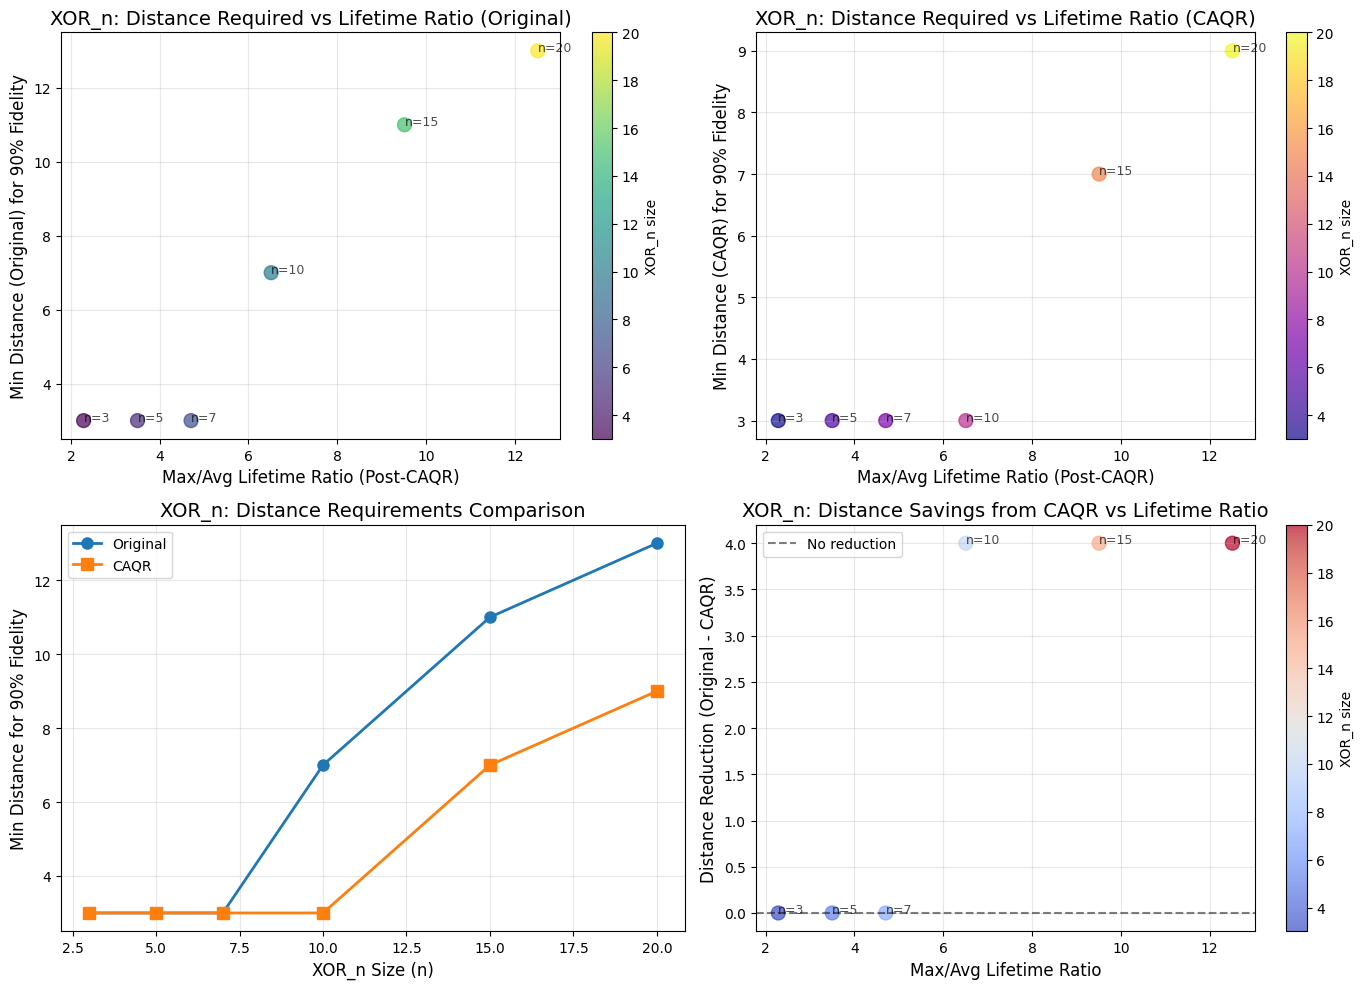


XOR_n DISTANCE REQUIREMENTS FOR 90% FIDELITY
  n |  Reuses |  Ratio |  d_orig |  d_caqr |    Δd |  F_orig |  F_caqr
------------------------------------------------------------------------------------------
  3 |       2 |   2.29 |       3 |       3 |     0 |  0.9560 |  0.9677
  5 |       4 |   3.50 |       3 |       3 |     0 |  0.9297 |  0.9491
  7 |       6 |   4.71 |       3 |       3 |     0 |  0.9036 |  0.9337
 10 |       9 |   6.51 |       7 |       3 |     4 |  0.9095 |  0.9056
 15 |      14 |   9.51 |      11 |       7 |     4 |  0.9142 |  0.9035
 20 |      19 |  12.52 |      13 |       9 |     4 |  0.9092 |  0.9023


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def analyze_distance_vs_lifetime_ratio(
    string_lengths: list,
    target_fidelity: float = 0.90,
    max_distance: int = 13,
    rounds: int = 10,
    p_phys_surface: float = 1e-2,
    shots_pL: int = 50_000,
    shots_bv: int = 20_000,
    use_bv: bool = True,
):
    results = []
    
    for n in string_lengths:
        print(f"\n{'='*60}")
        circuit_type = "BV" if use_bv else "XOR_n"
        print(f"Testing {circuit_type} with n={n}")
        print('='*60)
        
        if use_bv:
            s = '1' * n
            qc_seq = build_bv_circuit(s)
            secret = s
        else:
            xor_input = '1' * n
            qc_seq = build_xor_n_circuit(xor_input)
            secret = xor_parity(xor_input)
        
        qc_caqr, iter_count, chain = apply_caqr(qc_seq)
        
        print(f"CAQR: Reused {iter_count} qubits, Chain: {chain}")
        
        segments_caqr = qubit_segment_lifetimes(qc_caqr)
        all_segs_caqr = [seg for segs in segments_caqr for seg in segs]
        
        if len(all_segs_caqr) > 0:
            max_seg = max(all_segs_caqr)
            avg_seg = sum(all_segs_caqr) / len(all_segs_caqr)
            max_avg_ratio = max_seg / avg_seg if avg_seg > 0 else 0
        else:
            max_avg_ratio = 0
        
        print(f"Max/Avg lifetime ratio: {max_avg_ratio:.2f}")
        
        min_d_orig = None
        for d in range(3, max_distance + 1, 2):
            print(f"  Testing d={d} (original)...", end=" ")
            pL = estimate_pL_surface_code(
                distance=d,
                rounds=rounds,
                p_phys=p_phys_surface,
                shots=shots_pL
            )
            fidelity = run_bv_on_stim(qc_seq, secret, p1=pL, p2= 2 * pL, 
                                     shots=shots_bv, label=f"d={d}")
            print(f"F={fidelity:.4f}")
            
            if fidelity >= target_fidelity:
                min_d_orig = d
                fidelity_at_min_d_orig = fidelity
                break
        
        if min_d_orig is None:
            print(f"  ⚠️  Could not achieve {target_fidelity:.0%} fidelity (original)")
            min_d_orig = max_distance + 2 
            fidelity_at_min_d_orig = 0.0
        
        min_d_caqr = None
        for d in range(3, max_distance + 1, 2):
            print(f"  Testing d={d} (CAQR)...", end=" ")
            pL = estimate_pL_surface_code(
                distance=d,
                rounds=rounds,
                p_phys=p_phys_surface,
                shots=shots_pL
            )
            fidelity = run_bv_on_stim(qc_caqr, secret, p1=pL, p2=pL,
                                     shots=shots_bv, label=f"d={d}")
            print(f"F={fidelity:.4f}")
            
            if fidelity >= target_fidelity:
                min_d_caqr = d
                fidelity_at_min_d_caqr = fidelity
                break
        
        if min_d_caqr is None:
            print(f"  ⚠️  Could not achieve {target_fidelity:.0%} fidelity (CAQR)")
            min_d_caqr = max_distance + 2
            fidelity_at_min_d_caqr = 0.0
        
        print(f"✓ Min distance: Original={min_d_orig}, CAQR={min_d_caqr}")
        
        results.append({
            'n': n,
            'num_reuses': iter_count,
            'max_avg_ratio': max_avg_ratio,
            'min_d_orig': min_d_orig,
            'min_d_caqr': min_d_caqr,
            'distance_reduction': min_d_orig - min_d_caqr,
            'fidelity_orig': fidelity_at_min_d_orig,
            'fidelity_caqr': fidelity_at_min_d_caqr,
        })
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    ratios = [r['max_avg_ratio'] for r in results]
    min_d_orig = [r['min_d_orig'] for r in results]
    min_d_caqr = [r['min_d_caqr'] for r in results]
    distance_reductions = [r['distance_reduction'] for r in results]
    ns = [r['n'] for r in results]
    
    circuit_name = "BV" if use_bv else "XOR_n"
    
    scatter1 = axes[0, 0].scatter(ratios, min_d_orig, s=100, alpha=0.7, c=ns, cmap='viridis')
    axes[0, 0].set_xlabel('Max/Avg Lifetime Ratio (Post-CAQR)', fontsize=12)
    axes[0, 0].set_ylabel(f'Min Distance (Original) for {target_fidelity:.0%} Fidelity', fontsize=12)
    axes[0, 0].set_title(f'{circuit_name}: Distance Required vs Lifetime Ratio (Original)', fontsize=14)
    axes[0, 0].grid(True, alpha=0.3)
    plt.colorbar(scatter1, ax=axes[0, 0], label=f'{circuit_name} size')
    
    for i, r in enumerate(results):
        if r['min_d_orig'] <= max_distance:
            axes[0, 0].annotate(f"n={r['n']}", (ratios[i], min_d_orig[i]), 
                               fontsize=9, alpha=0.7)
    
    scatter2 = axes[0, 1].scatter(ratios, min_d_caqr, s=100, alpha=0.7, c=ns, cmap='plasma')
    axes[0, 1].set_xlabel('Max/Avg Lifetime Ratio (Post-CAQR)', fontsize=12)
    axes[0, 1].set_ylabel(f'Min Distance (CAQR) for {target_fidelity:.0%} Fidelity', fontsize=12)
    axes[0, 1].set_title(f'{circuit_name}: Distance Required vs Lifetime Ratio (CAQR)', fontsize=14)
    axes[0, 1].grid(True, alpha=0.3)
    plt.colorbar(scatter2, ax=axes[0, 1], label=f'{circuit_name} size')
    
    for i, r in enumerate(results):
        if r['min_d_caqr'] <= max_distance:
            axes[0, 1].annotate(f"n={r['n']}", (ratios[i], min_d_caqr[i]), 
                               fontsize=9, alpha=0.7)
    
    axes[1, 0].plot(ns, min_d_orig, 'o-', label='Original', linewidth=2, markersize=8)
    axes[1, 0].plot(ns, min_d_caqr, 's-', label='CAQR', linewidth=2, markersize=8)
    axes[1, 0].set_xlabel(f'{circuit_name} Size (n)', fontsize=12)
    axes[1, 0].set_ylabel(f'Min Distance for {target_fidelity:.0%} Fidelity', fontsize=12)
    axes[1, 0].set_title(f'{circuit_name}: Distance Requirements Comparison', fontsize=14)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    scatter4 = axes[1, 1].scatter(ratios, distance_reductions, s=100, alpha=0.7, c=ns, cmap='coolwarm')
    axes[1, 1].axhline(y=0, color='k', linestyle='--', alpha=0.5, label='No reduction')
    axes[1, 1].set_xlabel('Max/Avg Lifetime Ratio', fontsize=12)
    axes[1, 1].set_ylabel('Distance Reduction (Original - CAQR)', fontsize=12)
    axes[1, 1].set_title(f'{circuit_name}: Distance Savings from CAQR vs Lifetime Ratio', fontsize=14)
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].legend()
    plt.colorbar(scatter4, ax=axes[1, 1], label=f'{circuit_name} size')
    
    for i, r in enumerate(results):
        if r['min_d_orig'] <= max_distance and r['min_d_caqr'] <= max_distance:
            axes[1, 1].annotate(f"n={r['n']}", (ratios[i], distance_reductions[i]), 
                               fontsize=9, alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*90)
    print(f"{circuit_name} DISTANCE REQUIREMENTS FOR {target_fidelity:.0%} FIDELITY")
    print("="*90)
    print(f"{'n':>3} | {'Reuses':>7} | {'Ratio':>6} | {'d_orig':>7} | {'d_caqr':>7} | {'Δd':>5} | {'F_orig':>7} | {'F_caqr':>7}")
    print("-"*90)
    for r in results:
        print(f"{r['n']:3d} | {r['num_reuses']:7d} | {r['max_avg_ratio']:6.2f} | "
              f"{r['min_d_orig']:7d} | {r['min_d_caqr']:7d} | {r['distance_reduction']:5d} | "
              f"{r['fidelity_orig']:7.4f} | {r['fidelity_caqr']:7.4f}")
    
    return results

print("\n" + "="*90)
print("ANALYZING BV CIRCUITS")
print("="*90)
bv_distance_results = analyze_distance_vs_lifetime_ratio(
    string_lengths=[3, 4, 5, 6, 7, 8],
    target_fidelity=0.90,
    max_distance=13,
    rounds=10,
    p_phys_surface=1e-2,
    shots_pL=50_000,
    shots_bv=20_000,
    use_bv=True,
)

print("\n\n" + "="*90)
print("ANALYZING XOR_n CIRCUITS")
print("="*90)
xor_distance_results = analyze_distance_vs_lifetime_ratio(
    string_lengths=[3, 5, 7, 10, 15, 20],
    target_fidelity=0.90,
    max_distance=13,
    rounds=10,
    p_phys_surface=1e-2,
    shots_pL=50_000,
    shots_bv=20_000,
    use_bv=False,
)

In [ ]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import defaultdict
from scipy.optimize import curve_fit

def logistic_model(x, L, k, x0, b):
    return L / (1 + np.exp(-k * (np.log10(x) - x0))) + b

def get_active_qubit_count(qc: QuantumCircuit) -> int:
    used_qubits = set()
    for instruction in qc.data:
        for q in instruction.qubits:
            used_qubits.add(q)
    return len(used_qubits)

def circuit_space_time_volume(qc) -> int:
    return get_active_qubit_count(qc) * qc.depth()

def physical_space_time_volume(qc, distance: int, rounds_per_layer: int = None) -> int:
    n_logical = get_active_qubit_count(qc) # otherwise reuse is not credited
    depth = qc.depth()
    
    if rounds_per_layer is None:
        rounds_per_layer = distance
    
    space = n_logical * (distance ** 2)
    time = depth * rounds_per_layer
    
    return space * time


def analyze_fidelity_vs_space_time(
    string_lengths,
    distances,
    rounds: int = 10,
    p_phys_surface: float = 1e-2,
    shots_pL: int = 50_000,
    shots_algo: int = 20_000,
    use_bv: bool = True,
):
    results = []

    circuit_name = "BV" if use_bv else "XOR_n"

    for n in tqdm(string_lengths, desc="Circuit Sizes"):

        if use_bv:
            secret = "1" * n 
            qc_seq = build_bv_circuit(secret)
        else:
            xor_input = "1" * n 
            qc_seq = build_xor_n_circuit(xor_input)
            secret = xor_parity(xor_input)

        qc_caqr, iter_count, _ = apply_caqr(qc_seq)

        for d in tqdm(distances, desc=f"Distances (n={n})", leave=False):

            pL = estimate_pL_surface_code(
                distance=d,
                rounds=rounds,
                p_phys=p_phys_surface,
                shots=shots_pL,
            )

            p1 = pL
            p2 = 2 * pL

            F_orig = run_bv_on_stim(
                qc_seq,
                secret,
                p1=p1,
                p2=p2,
                shots=shots_algo,
                label=f"{circuit_name} orig (n={n}, d={d})",
            )

            F_caqr = run_bv_on_stim(
                qc_caqr,
                secret,
                p1=p1,
                p2=p2,
                shots=shots_algo,
                label=f"{circuit_name} CAQR (n={n}, d={d})",
            )

            V_orig = physical_space_time_volume(
                qc_seq,
                distance=d,
            )
            V_caqr = physical_space_time_volume(
                qc_caqr,
                distance=d,
            )

            results.append({
                "n": n,
                "d": d,
                "reuses": iter_count,
                "V_orig": V_orig,
                "V_caqr": V_caqr,
                "F_orig": F_orig,
                "F_caqr": F_caqr,
            })

    fig, ax = plt.subplots(figsize=(8, 6))

    V_orig_all = [r['V_orig'] for r in results]
    F_orig_all = [r['F_orig'] for r in results]
    V_caqr_all = [r['V_caqr'] for r in results]
    F_caqr_all = [r['F_caqr'] for r in results]

    orig_by_d = defaultdict(lambda: {'V': [], 'F': []})
    caqr_by_d = defaultdict(lambda: {'V': [], 'F': []})
    
    for r in results:
        d = r['d']
        orig_by_d[d]['V'].append(r['V_orig'])
        orig_by_d[d]['F'].append(r['F_orig'])
        caqr_by_d[d]['V'].append(r['V_caqr'])
        caqr_by_d[d]['F'].append(r['F_caqr'])
    
    V_o_avg = []
    F_o_avg = []
    V_c_avg = []
    F_c_avg = []
    distances_used = sorted(orig_by_d.keys())
    
    for d in distances_used:
        V_o_avg.append(np.mean(orig_by_d[d]['V']))
        F_o_avg.append(np.mean(orig_by_d[d]['F']))
        V_c_avg.append(np.mean(caqr_by_d[d]['V']))
        F_c_avg.append(np.mean(caqr_by_d[d]['F']))
    
    V_o_avg = np.array(V_o_avg)
    F_o_avg = np.array(F_o_avg)
    V_c_avg = np.array(V_c_avg)
    F_c_avg = np.array(F_c_avg)
    
    ax.set_xscale("log")

    ax.scatter(V_orig_all, F_orig_all, marker="o", s=30, alpha=0.4, color='blue', label="Original (all)")
    ax.scatter(V_caqr_all, F_caqr_all, marker="s", s=30, alpha=0.4, color='orange', label="CAQR (all)")
    
    if len(V_o_avg) > 3:
        p0_o = [1.0 - F_o_avg.min(), 1.0, np.log10(np.median(V_o_avg)), F_o_avg.min()]
        popt_o, _ = curve_fit(logistic_model, V_o_avg, F_o_avg, p0=p0_o, maxfev=5000)
        
        V_o_fit = np.logspace(np.log10(V_o_avg.min()), np.log10(V_o_avg.max()), 100)
        F_o_fit = logistic_model(V_o_fit, *popt_o)
        ax.plot(V_o_fit, F_o_fit, "b-", alpha=0.8, linewidth=3, 
                label=f"Fit Orig")
    if len(V_c_avg) > 3:
        p0_c = [1.0 - F_c_avg.min(), 1.0, np.log10(np.median(V_c_avg)), F_c_avg.min()]
        popt_c, _ = curve_fit(logistic_model, V_c_avg, F_c_avg, p0=p0_c, maxfev=5000)
        
        V_c_fit = np.logspace(np.log10(V_c_avg.min()), np.log10(V_c_avg.max()), 100)
        F_c_fit = logistic_model(V_c_fit, *popt_c)
        ax.plot(V_c_fit, F_c_fit, color="orange", linestyle="-", alpha=0.8, linewidth=3,
                label=f"Fit CAQR")

    ax.set_xlabel("Approx. space–time volume", fontsize=12)
    ax.set_ylabel("Fidelity", fontsize=12)
    ax.set_title(f"{circuit_name}: Fidelity vs space–time volume", fontsize=14)
    ax.set_ylim(0, 1.05)
    ax.grid(True, alpha=0.3)
    ax.legend()

    plt.tight_layout()
    plt.show()
    return results

In [16]:
from qiskit import QuantumCircuit

def build_ghz_circuit(n: int) -> QuantumCircuit:
    qc = QuantumCircuit(n, n)

    qc.h(0)

    for i in range(n - 1):
        qc.cx(i, i + 1)

    qc.measure(range(n), range(n))

    return qc


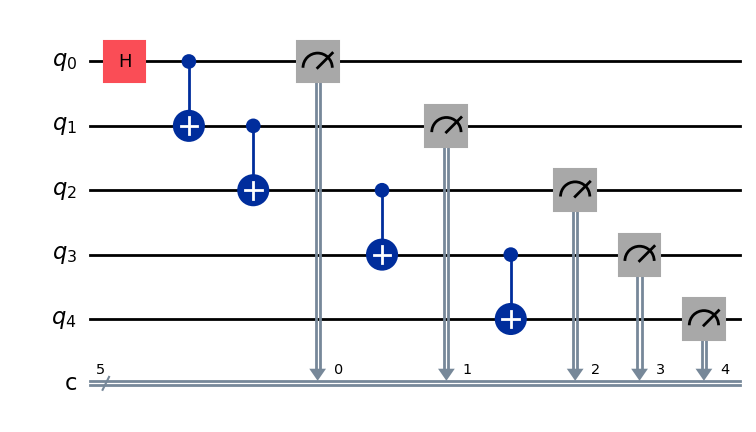

{'11111': 1025, '00000': 975}


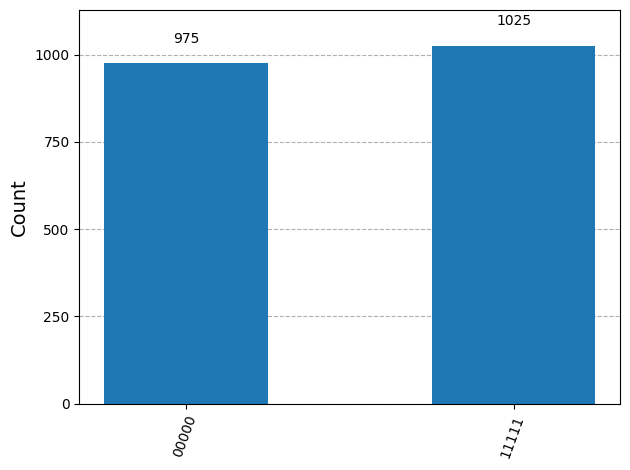

In [17]:
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

n = 5
qc_ghz = build_ghz_circuit(n)
display(qc_ghz.draw("mpl"))

sim = AerSimulator()
result = sim.run(qc_ghz, shots=2000).result()
counts = result.get_counts()

print(counts)            # should be ~50/50 between '0'*n and '1'*n (up to noise)
display(plot_histogram(counts))


In [ ]:
import stim
from qiskit import QuantumCircuit

def test_ghz_stim(
    qc: QuantumCircuit,
    n: int,
    p1: float = 0.0,
    p2: float = 0.0,
    shots: int = 10_000,
    circuit_name: str = "GHZ"
) -> dict:
    stim_circuit = qiskit_to_stim_circuit_with_noise(qc, p1=p1, p2=p2)
    
    sampler = stim_circuit.compile_sampler()
    samples = sampler.sample(shots)
    
    all_zeros = '0' * n
    all_ones = '1' * n
    counts = {}
    
    for shot in samples:
        bitstring = ''.join(str(int(b)) for b in shot[:n][::-1])
        counts[bitstring] = counts.get(bitstring, 0) + 1
    
    p_all_zeros = counts.get(all_zeros, 0) / shots
    p_all_ones = counts.get(all_ones, 0) / shots
    p_other = 1.0 - p_all_zeros - p_all_ones
    
    is_valid = (p_all_zeros > 0.4 and p_all_ones > 0.4)
    
    print(f"\n--- {circuit_name} (n={n}) ---")
    print(f"Shots: {shots}")
    print(f"All-0s: {counts.get(all_zeros, 0):5d} ({p_all_zeros:.4f})")
    print(f"All-1s: {counts.get(all_ones, 0):5d} ({p_all_ones:.4f})")
    print(f"Other:  {int(p_other * shots):5d} ({p_other:.4f})")
    
    if is_valid:
        print("SUCCESS: Valid GHZ distribution!")
    else:
        print(f"FAILED: Expected ~50/50 split, got {p_all_zeros:.2%}/{p_all_ones:.2%}")
    
    print("\nTop 5 outcomes:")
    for bitstring, count in sorted(counts.items(), key=lambda x: x[1], reverse=True)[:5]:
        pct = 100 * count / shots
        print(f"  {bitstring}: {count:4d} ({pct:5.1f}%)")
    
    return {
        'all_zeros_prob': p_all_zeros,
        'all_ones_prob': p_all_ones,
        'other_prob': p_other,
        'is_valid': is_valid,
        'counts': counts
    }


n = 5
qc_ghz = build_ghz_circuit(n)
qc_ghz_caqr, ghz_reuses, ghz_chain = apply_caqr(qc_ghz)

print(f"GHZ circuit: {n} qubits")
print(f"CAQR reused {ghz_reuses} qubits")
print(f"Reuse chain: {ghz_chain}")

print("\n" + "="*60)
print("TESTING WITHOUT NOISE")
print("="*60)
result_orig = test_ghz_stim(qc_ghz, n, p1=0.0, p2=0.0, 
                            circuit_name="GHZ Original")
result_caqr = test_ghz_stim(qc_ghz_caqr, n, p1=0.0, p2=0.0,
                            circuit_name="GHZ CAQR")

print("\n" + "="*60)
print("TESTING WITH LOGICAL NOISE (d=5)")
print("="*60)
pL = estimate_pL_surface_code(distance=5, rounds=10, p_phys=1e-2, shots=50_000)
print(f"Logical error rate: p_L = {pL:.4e}\n")

result_orig_noisy = test_ghz_stim(qc_ghz, n, p1=pL, p2=2*pL,
                                   circuit_name="GHZ Original (noisy)")
result_caqr_noisy = test_ghz_stim(qc_ghz_caqr, n, p1=pL, p2=2*pL,
                                   circuit_name="GHZ CAQR (noisy)")

print("\n" + "="*60)
print("COMPARISON")
print("="*60)
print(f"Original - No noise:  All-0s={result_orig['all_zeros_prob']:.4f}, All-1s={result_orig['all_ones_prob']:.4f}")
print(f"CAQR     - No noise:  All-0s={result_caqr['all_zeros_prob']:.4f}, All-1s={result_caqr['all_ones_prob']:.4f}")
print(f"Original - Noisy:     All-0s={result_orig_noisy['all_zeros_prob']:.4f}, All-1s={result_orig_noisy['all_ones_prob']:.4f}")
print(f"CAQR     - Noisy:     All-0s={result_caqr_noisy['all_zeros_prob']:.4f}, All-1s={result_caqr_noisy['all_ones_prob']:.4f}")

GHZ circuit: 5 qubits
CAQR reused 3 qubits
Reuse chain: [(0, 2), (0, 4), (1, 3)]

TESTING WITHOUT NOISE

--- GHZ Original (n=5) ---
Shots: 10000
All-0s:  5006 (0.5006)
All-1s:  4994 (0.4994)
Other:      0 (-0.0000)
✓ SUCCESS: Valid GHZ distribution!

Top 5 outcomes:
  00000: 5006 ( 50.1%)
  11111: 4994 ( 49.9%)

--- GHZ CAQR (n=5) ---
Shots: 10000
All-0s:  4972 (0.4972)
All-1s:  5028 (0.5028)
Other:      0 (0.0000)
✓ SUCCESS: Valid GHZ distribution!

Top 5 outcomes:
  11111: 5028 ( 50.3%)
  00000: 4972 ( 49.7%)

TESTING WITH LOGICAL NOISE (d=5)
Logical error rate: p_L = 7.4620e-03


--- GHZ Original (noisy) (n=5) ---
Shots: 10000
All-0s:  4863 (0.4863)
All-1s:  4748 (0.4748)
Other:    389 (0.0389)
✓ SUCCESS: Valid GHZ distribution!

Top 5 outcomes:
  00000: 4863 ( 48.6%)
  11111: 4748 ( 47.5%)
  11110:   46 (  0.5%)
  00001:   45 (  0.5%)
  00111:   42 (  0.4%)

--- GHZ CAQR (noisy) (n=5) ---
Shots: 10000
All-0s:  4855 (0.4855)
All-1s:  4741 (0.4741)
Other:    403 (0.0404)
✓ SUCCESS: V

In [19]:
def run_ghz_on_stim(
    qc: QuantumCircuit,
    n: int,
    p1: float = 0.0,
    p2: float = 0.0,
    shots: int = 10_000,
) -> dict:
    stim_circuit = qiskit_to_stim_circuit_with_noise(qc, p1=p1, p2=p2)
    
    sampler = stim_circuit.compile_sampler()
    samples = sampler.sample(shots)
    
    all_zeros = '0' * n
    all_ones = '1' * n
    counts = {}
    
    for shot in samples:
        bitstring = ''.join(str(int(b)) for b in shot[:n][::-1])
        counts[bitstring] = counts.get(bitstring, 0) + 1
    
    p_all_zeros = counts.get(all_zeros, 0) / shots
    p_all_ones = counts.get(all_ones, 0) / shots
    p_other = 1.0 - p_all_zeros - p_all_ones
    
    is_valid = (p_all_zeros > 0.4 and p_all_ones > 0.4)

    return {
        'all_zeros_prob': p_all_zeros,
        'all_ones_prob': p_all_ones,
        'other_prob': p_other,
        'is_valid': is_valid,
        'counts': counts
    }

In [ ]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import defaultdict
from scipy.optimize import curve_fit

def logistic_model(x, L, k, x0, b):
    return L / (1 + np.exp(-k * (np.log10(x) - x0))) + b

def get_active_qubit_count(qc: QuantumCircuit) -> int:
    used_qubits = set()
    for instruction in qc.data:
        for q in instruction.qubits:
            used_qubits.add(q)
    return len(used_qubits)

def physical_space_time_volume(qc, distance: int, rounds_per_layer: int = None) -> int:
    n_logical = get_active_qubit_count(qc)
    depth = qc.depth()
    
    if rounds_per_layer is None:
        rounds_per_layer = distance
    
    space = n_logical * (distance ** 2)
    time = depth * rounds_per_layer
    
    return space * time


def analyze_fidelity_vs_space_time(
    string_lengths,
    distances,
    rounds: int = 10,
    p_phys_surface: float = 1e-2,
    shots_pL: int = 50_000,
    shots_algo: int = 20_000,
    circuit_type: str = "bv",
):
    results = []
    
    circuit_name = {"bv": "BV", "xor": "XOR_n", "ghz": "GHZ"}[circuit_type]

    for n in tqdm(string_lengths, desc="Circuit Sizes"):

        if circuit_type == "bv":
            secret = "1" * n 
            qc_seq = build_bv_circuit(secret)
            expected_outcome = secret
        elif circuit_type == "xor":
            xor_input = "1" * n 
            qc_seq = build_xor_n_circuit(xor_input)
            expected_outcome = xor_parity(xor_input)
        elif circuit_type == "ghz":
            qc_seq = build_ghz_circuit(n)
            expected_outcome = None
        else:
            raise ValueError(f"Unknown circuit_type: {circuit_type}")

        qc_caqr, iter_count, _ = apply_caqr(qc_seq)

        for d in tqdm(distances, desc=f"Distances (n={n})", leave=False):

            pL = estimate_pL_surface_code(
                distance=d,
                rounds=rounds,
                p_phys=p_phys_surface,
                shots=shots_pL,
            )

            p1 = pL
            p2 = 2 * pL

            if circuit_type == "ghz":
                result_orig = run_ghz_on_stim(qc_seq, n, p1=p1, p2=p2, 
                                           shots=shots_algo)
                F_orig = result_orig['all_zeros_prob'] + result_orig['all_ones_prob']
            else:
                F_orig = run_bv_on_stim(
                    qc_seq,
                    expected_outcome,
                    p1=p1,
                    p2=p2,
                    shots=shots_algo
                )

            if circuit_type == "ghz":
                result_caqr = run_ghz_on_stim(qc_caqr, n, p1=p1, p2=p2,
                                            shots=shots_algo)
                F_caqr = result_caqr['all_zeros_prob'] + result_caqr['all_ones_prob']
            else:
                F_caqr = run_bv_on_stim(
                    qc_caqr,
                    expected_outcome,
                    p1=p1,
                    p2=p2,
                    shots=shots_algo)

            V_orig = physical_space_time_volume(qc_seq, distance=d)
            V_caqr = physical_space_time_volume(qc_caqr, distance=d)

            results.append({
                "n": n,
                "d": d,
                "reuses": iter_count,
                "V_orig": V_orig,
                "V_caqr": V_caqr,
                "F_orig": F_orig,
                "F_caqr": F_caqr,
            })

    fig, ax = plt.subplots(figsize=(8, 6))

    V_orig_all = [r['V_orig'] for r in results]
    F_orig_all = [r['F_orig'] for r in results]
    V_caqr_all = [r['V_caqr'] for r in results]
    F_caqr_all = [r['F_caqr'] for r in results]

    orig_by_d = defaultdict(lambda: {'V': [], 'F': []})
    caqr_by_d = defaultdict(lambda: {'V': [], 'F': []})
    
    for r in results:
        d = r['d']
        orig_by_d[d]['V'].append(r['V_orig'])
        orig_by_d[d]['F'].append(r['F_orig'])
        caqr_by_d[d]['V'].append(r['V_caqr'])
        caqr_by_d[d]['F'].append(r['F_caqr'])
    
    V_o_avg = []
    F_o_avg = []
    V_c_avg = []
    F_c_avg = []
    distances_used = sorted(orig_by_d.keys())
    
    for d in distances_used:
        V_o_avg.append(np.mean(orig_by_d[d]['V']))
        F_o_avg.append(np.mean(orig_by_d[d]['F']))
        V_c_avg.append(np.mean(caqr_by_d[d]['V']))
        F_c_avg.append(np.mean(caqr_by_d[d]['F']))
    
    V_o_avg = np.array(V_o_avg)
    F_o_avg = np.array(F_o_avg)
    V_c_avg = np.array(V_c_avg)
    F_c_avg = np.array(F_c_avg)
    
    ax.set_xscale("log")

    ax.scatter(V_orig_all, F_orig_all, marker="o", s=30, alpha=0.4, color='blue', 
               label="Original (all)")
    ax.scatter(V_caqr_all, F_caqr_all, marker="s", s=30, alpha=0.4, color='orange', 
               label="CAQR (all)")
    
    # Fit logistic curves
    if len(V_o_avg) > 3:
        try:
            p0_o = [1.0 - F_o_avg.min(), 1.0, np.log10(np.median(V_o_avg)), F_o_avg.min()]
            popt_o, _ = curve_fit(logistic_model, V_o_avg, F_o_avg, p0=p0_o, maxfev=5000)
            
            V_o_fit = np.logspace(np.log10(V_o_avg.min()), np.log10(V_o_avg.max()), 100)
            F_o_fit = logistic_model(V_o_fit, *popt_o)
            ax.plot(V_o_fit, F_o_fit, "b-", alpha=0.8, linewidth=3, label="Fit Orig")
        except:
            print("Warning: Could not fit original data")
            
    if len(V_c_avg) > 3:
        try:
            p0_c = [1.0 - F_c_avg.min(), 1.0, np.log10(np.median(V_c_avg)), F_c_avg.min()]
            popt_c, _ = curve_fit(logistic_model, V_c_avg, F_c_avg, p0=p0_c, maxfev=5000)
            
            V_c_fit = np.logspace(np.log10(V_c_avg.min()), np.log10(V_c_avg.max()), 100)
            F_c_fit = logistic_model(V_c_fit, *popt_c)
            ax.plot(V_c_fit, F_c_fit, color="orange", linestyle="-", alpha=0.8, 
                   linewidth=3, label="Fit CAQR")
        except:
            print("Warning: Could not fit CAQR data")

    ax.set_xlabel("Physical space–time volume", fontsize=12)
    ax.set_ylabel("Fidelity", fontsize=12)
    ax.set_title(f"{circuit_name}: Fidelity vs space–time volume", fontsize=14)
    ax.set_ylim(0, 1.05)
    ax.grid(True, alpha=0.3)
    ax.legend()

    plt.tight_layout()
    plt.show()
    
    return results

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

def build_simon_circuit(n: int, s: str) -> QuantumCircuit:
    if len(s) != n:
        raise ValueError(f"Secret string length {len(s)} must match n={n}")
    
    qr_in = QuantumRegister(n, 'x')
    qr_out = QuantumRegister(n, 'y')
    cr = ClassicalRegister(n, 'meas')
    
    qc = QuantumCircuit(qr_in, qr_out, cr)
    
    qc.h(qr_in)
    
    # Oracle (built directly into circuit)
    s_rev = s[::-1]
    
    # Find pivot
    pivot = -1
    for i, bit in enumerate(s_rev):
        if bit == '1':
            pivot = i
            break
    
    # Build oracle gates
    for i in range(n):
        if pivot == -1:
            qc.cx(qr_in[i], qr_out[i])
            continue
            
        if i == pivot:
            continue
            
        qc.cx(qr_in[i], qr_out[i])
        
        if s_rev[i] == '1':
            qc.cx(qr_in[pivot], qr_out[i])
    
    qc.h(qr_in)
    
    qc.measure(qr_in, cr)
    
    return qc

def test_simon():
    n = 12
    secret = "110101011110"  # We expect all outputs z to satisfy z · 110 = 0
    
    qc = build_simon_circuit(n, secret)
    sim = AerSimulator()
    result = sim.run(qc, shots=1000).result()
    counts = result.get_counts()
    
    print(f"Testing Secret: {secret}")
    print(f"Counts: {counts}")
    
    s_int = int(secret, 2)
    success = True
    
    for meas_str in counts:
        meas_int = int(meas_str, 2)
        dot_product = bin(meas_int & s_int).count('1') % 2
        
        if dot_product != 0:
            print(f"FAIL: Output {meas_str} is NOT orthogonal to {secret}")
            success = False
            
    if success:
        print("SUCCESS: All outputs orthogonal.")

test_simon()

Testing Secret: 110101011110
Counts: {'111111010100': 1, '011010011100': 1, '001011010000': 1, '100111001111': 3, '001100001110': 1, '101010110001': 2, '000000111001': 1, '111000011000': 2, '101000110110': 1, '001111000000': 1, '011110100110': 1, '111101010100': 1, '011100001011': 2, '110111011110': 1, '111001100010': 1, '010011101011': 2, '110000100000': 1, '001110010001': 2, '110011101110': 1, '001001010000': 1, '110011000011': 2, '100010100100': 1, '010111000100': 2, '100100000001': 1, '110010000111': 2, '010110000001': 2, '011000011010': 1, '110101100110': 1, '001000011111': 2, '110100101001': 1, '110001001000': 3, '101110011001': 1, '110100000100': 2, '001011010111': 1, '101001110101': 1, '110101011111': 1, '010101110001': 2, '010001111000': 1, '011110111000': 1, '101111010111': 1, '011001010100': 1, '110100001001': 1, '100110001101': 2, '011101001111': 2, '101110010100': 1, '001011101110': 1, '011101000011': 2, '100010001000': 1, '010010100011': 2, '111100100010': 1, '11010010010

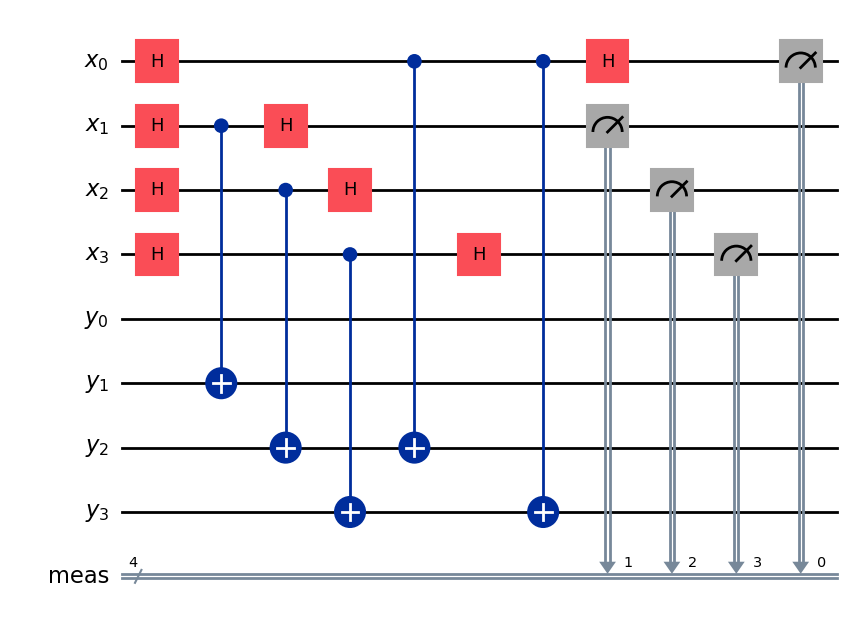

In [ ]:
qc_simon = build_simon_circuit(4, "1101")
display(qc_simon.draw("mpl"))

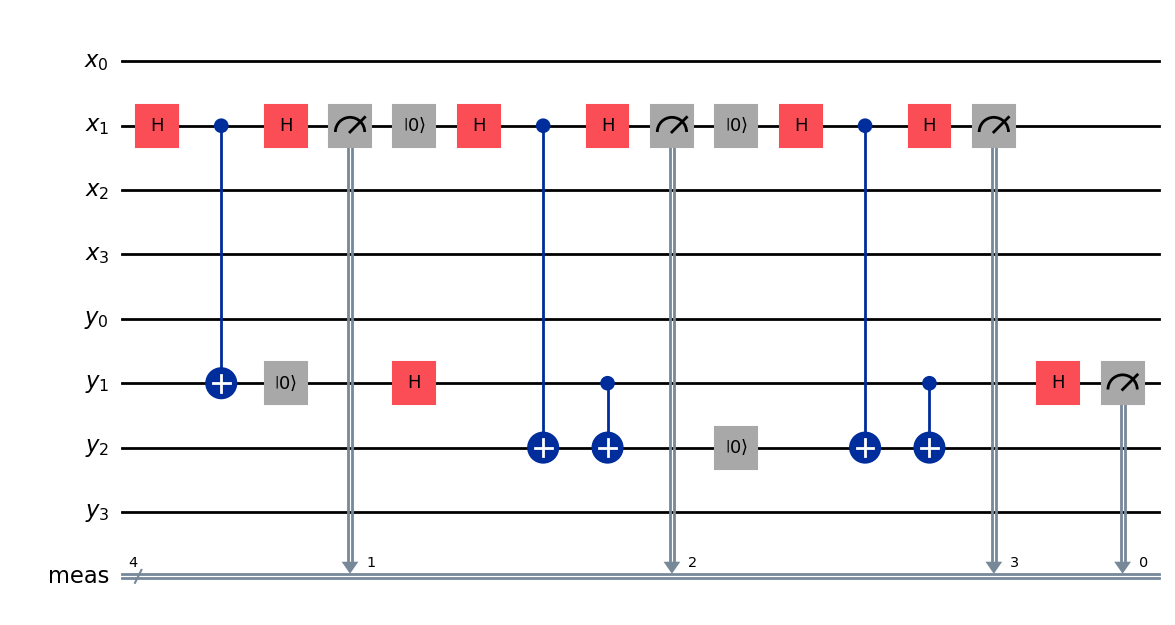

: 

In [ ]:
qc_simon_caqr, _, _ = apply_caqr(qc_simon)
display(qc_simon_caqr.draw("mpl"))

In [ ]:
def run_simon_on_stim(
    qc: QuantumCircuit,
    secret_s: str,
    p1: float = 0.0,
    p2: float = 0.0,
    shots: int = 20_000,
) -> float:
    n = len(secret_s)
    
    stim_circuit = qiskit_to_stim_circuit_with_noise(qc, p1=p1, p2=p2)
    
    meas_map = []
    meas_counter = 0
    clbit_index = {cb: idx for idx, cb in enumerate(qc.clbits)}
    
    for gate in qc:
        op_name = gate.operation.name.lower()
        if op_name == "measure":
            cbit = gate.clbits[0]
            c_idx = clbit_index[cbit]
            meas_map.append((meas_counter, c_idx))
            meas_counter += 1
    
    sampler = stim_circuit.compile_sampler()
    samples = sampler.sample(shots)
    
    # Check orthogonality
    s_int = int(secret_s, 2)
    valid_count = 0
    
    for shot in samples:
        # Reconstruct measurement bitstring
        cvals = [0] * n
        for meas_idx, c_idx in meas_map:
            if c_idx < n:
                cvals[c_idx] = int(shot[meas_idx])
        
        # Convert to integer
        z_int = int(''.join(str(cvals[i]) for i in range(n-1, -1, -1)), 2)
        
        # Check orthogonality: z · s = 0 (mod 2)
        dot_product = bin(z_int & s_int).count('1') % 2
        
        if dot_product == 0:
            valid_count += 1
    
    fidelity = valid_count / shots
    return fidelity

In [ ]:
def analyze_fidelity_vs_space_time(
    string_lengths,
    distances,
    rounds: int = 10,
    p_phys_surface: float = 1e-2,
    shots_pL: int = 50_000,
    shots_algo: int = 20_000,
    circuit_type: str = "bv",  # "bv", "xor", "ghz", or "simon"
):
    results = []
    
    circuit_name = {"bv": "BV", "xor": "XOR_n", "ghz": "GHZ", "simon": "Simon"}[circuit_type]

    for n in tqdm(string_lengths, desc="Circuit Sizes"):

        if circuit_type == "bv":
            secret = "1" * n 
            qc_seq = build_bv_circuit(secret)
            expected_outcome = secret
        elif circuit_type == "xor":
            xor_input = "1" * n 
            qc_seq = build_xor_n_circuit(xor_input)
            expected_outcome = xor_parity(xor_input)
        elif circuit_type == "ghz":
            qc_seq = build_ghz_circuit(n)
            expected_outcome = None
        elif circuit_type == "simon":
            secret = "1" + "01" * ((n-1)//2) + ("0" if n % 2 == 0 else "")
            secret = secret[:n]
            qc_seq = build_simon_circuit(n, secret)
            expected_outcome = secret
        else:
            raise ValueError(f"Unknown circuit_type: {circuit_type}")

        qc_caqr, iter_count, _ = apply_caqr(qc_seq)

        for d in tqdm(distances, desc=f"Distances (n={n})", leave=False):

            pL = estimate_pL_surface_code(
                distance=d,
                rounds=rounds,
                p_phys=p_phys_surface,
                shots=shots_pL,
            )

            p1 = pL
            p2 = 2 * pL

            if circuit_type == "ghz":
                result_orig = run_ghz_on_stim(qc_seq, n, p1=p1, p2=p2, 
                                           shots=shots_algo)
                F_orig = result_orig['all_zeros_prob'] + result_orig['all_ones_prob']
            elif circuit_type == "simon":
                F_orig = run_simon_on_stim(qc_seq, expected_outcome, p1=p1, p2=p2,
                                          shots=shots_algo)
            else:
                F_orig = run_bv_on_stim(qc_seq, expected_outcome, p1=p1, p2=p2,
                                       shots=shots_algo)

            if circuit_type == "ghz":
                result_caqr = run_ghz_on_stim(qc_caqr, n, p1=p1, p2=p2,
                                            shots=shots_algo)
                F_caqr = result_caqr['all_zeros_prob'] + result_caqr['all_ones_prob']
            elif circuit_type == "simon":
                F_caqr = run_simon_on_stim(qc_caqr, expected_outcome, p1=p1, p2=p2,
                                          shots=shots_algo)
            else:
                F_caqr = run_bv_on_stim(qc_caqr, expected_outcome, p1=p1, p2=p2,
                                       shots=shots_algo)

            V_orig = physical_space_time_volume(qc_seq, distance=d)
            V_caqr = physical_space_time_volume(qc_caqr, distance=d)

            results.append({
                "n": n,
                "d": d,
                "reuses": iter_count,
                "V_orig": V_orig,
                "V_caqr": V_caqr,
                "F_orig": F_orig,
                "F_caqr": F_caqr,
            })

    fig, ax = plt.subplots(figsize=(8, 6))

    V_orig_all = [r['V_orig'] for r in results]
    F_orig_all = [r['F_orig'] for r in results]
    V_caqr_all = [r['V_caqr'] for r in results]
    F_caqr_all = [r['F_caqr'] for r in results]

    orig_by_d = defaultdict(lambda: {'V': [], 'F': []})
    caqr_by_d = defaultdict(lambda: {'V': [], 'F': []})
    
    for r in results:
        d = r['d']
        orig_by_d[d]['V'].append(r['V_orig'])
        orig_by_d[d]['F'].append(r['F_orig'])
        caqr_by_d[d]['V'].append(r['V_caqr'])
        caqr_by_d[d]['F'].append(r['F_caqr'])
    
    V_o_avg = []
    F_o_avg = []
    V_c_avg = []
    F_c_avg = []
    distances_used = sorted(orig_by_d.keys())
    
    for d in distances_used:
        V_o_avg.append(np.mean(orig_by_d[d]['V']))
        F_o_avg.append(np.mean(orig_by_d[d]['F']))
        V_c_avg.append(np.mean(caqr_by_d[d]['V']))
        F_c_avg.append(np.mean(caqr_by_d[d]['F']))
    
    V_o_avg = np.array(V_o_avg)
    F_o_avg = np.array(F_o_avg)
    V_c_avg = np.array(V_c_avg)
    F_c_avg = np.array(F_c_avg)
    
    ax.set_xscale("log")

    ax.scatter(V_orig_all, F_orig_all, marker="o", s=30, alpha=0.4, color='blue', 
               label="Original (all)")
    ax.scatter(V_caqr_all, F_caqr_all, marker="s", s=30, alpha=0.4, color='orange', 
               label="CAQR (all)")
    
    if len(V_o_avg) > 3:
        try:
            p0_o = [1.0 - F_o_avg.min(), 1.0, np.log10(np.median(V_o_avg)), F_o_avg.min()]
            popt_o, _ = curve_fit(logistic_model, V_o_avg, F_o_avg, p0=p0_o, maxfev=5000)
            
            V_o_fit = np.logspace(np.log10(V_o_avg.min()), np.log10(V_o_avg.max()), 100)
            F_o_fit = logistic_model(V_o_fit, *popt_o)
            ax.plot(V_o_fit, F_o_fit, "b-", alpha=0.8, linewidth=3, label="Fit Orig")
        except:
            print("Warning: Could not fit original data")
            
    if len(V_c_avg) > 3:
        try:
            p0_c = [1.0 - F_c_avg.min(), 1.0, np.log10(np.median(V_c_avg)), F_c_avg.min()]
            popt_c, _ = curve_fit(logistic_model, V_c_avg, F_c_avg, p0=p0_c, maxfev=5000)
            
            V_c_fit = np.logspace(np.log10(V_c_avg.min()), np.log10(V_c_avg.max()), 100)
            F_c_fit = logistic_model(V_c_fit, *popt_c)
            ax.plot(V_c_fit, F_c_fit, color="orange", linestyle="-", alpha=0.8, 
                   linewidth=3, label="Fit CAQR")
        except:
            print("Warning: Could not fit CAQR data")

    ax.set_xlabel("Physical space–time volume", fontsize=12)
    ax.set_ylabel("Fidelity", fontsize=12)
    ax.set_title(f"{circuit_name}: Fidelity vs space–time volume", fontsize=14)
    ax.set_ylim(0, 1.05)
    ax.grid(True, alpha=0.3)
    ax.legend()

    plt.tight_layout()
    plt.show()
    
    return results

In [ ]:
def get_active_qubit_count(qc: QuantumCircuit) -> int:
    used_qubits = set()
    for instruction in qc.data:
        for q in instruction.qubits:
            used_qubits.add(q)
    return len(used_qubits)

def basic_stats(qc):
    depth = qc.depth()
    num_qubits = get_active_qubit_count(qc)
    num_twoq = sum(1 for inst, qargs, cargs in qc.data if inst.name in ("cx","cz"))
    return depth, num_qubits, num_twoq

for n in [3,5,7,9,11]:
    secret = "1" * n
    qc = build_simon_circuit(n, secret)
    qc_caqr, iter_count, _ = apply_caqr(qc)
    
    d0, q0, t0 = basic_stats(qc)
    d1, q1, t1 = basic_stats(qc_caqr)
    print(f"n={n}: orig depth={d0}, qubits={q0}, 2q={t0}")
    print(f"     CAQR depth={d1}, qubits={q1}, 2q={t1}, reuses={iter_count}")


n=3: orig depth=6, qubits=5, 2q=4
     CAQR depth=13, qubits=3, 2q=4, reuses=2
n=5: orig depth=8, qubits=9, 2q=8
     CAQR depth=25, qubits=5, 2q=8, reuses=4


C:\Users\yasit\AppData\Local\Temp\ipykernel_14416\1326741261.py:11: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  num_twoq = sum(1 for inst, qargs, cargs in qc.data if inst.name in ("cx","cz"))


n=7: orig depth=10, qubits=13, 2q=12
     CAQR depth=37, qubits=7, 2q=12, reuses=6
n=9: orig depth=12, qubits=17, 2q=16
     CAQR depth=49, qubits=9, 2q=16, reuses=8
n=11: orig depth=14, qubits=21, 2q=20
     CAQR depth=61, qubits=11, 2q=20, reuses=10


In [25]:
# # Run analysis for Deutsch-Jozsa algorithm
# distances = [n for n in range(3, 13, 2)]
# lengths = [n for n in range(3, 51, 8)]
# rounds = 10
# p_phys_surface = 1e-2
# shots_pL = 50_000
# shots_algo = 20_000

# print("\n" + "=" * 90)
# print("FIDELITY vs SPACE–TIME VOLUME – DEUTSCH-JOZSA ALGORITHM")
# print("=" * 90)
# dj_volume_results = analyze_fidelity_vs_space_time(
#     string_lengths=lengths,
#     distances=distances,
#     rounds=rounds,
#     p_phys_surface=p_phys_surface,
#     shots_pL=shots_pL,
#     shots_algo=shots_algo,
#     circuit_type="dj",
# )

In [ ]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator


def build_repetition_code_circuit(
    distance: int,
    logical_state: str = "0",
    inject_error_qubit: int | None = None,
) -> QuantumCircuit:
    if distance < 1:
        raise ValueError("distance must be >= 1")
    if logical_state not in {"0", "1"}:
        raise ValueError("logical_state must be '0' or '1'")
    if inject_error_qubit is not None and not (0 <= inject_error_qubit < distance):
        raise ValueError("inject_error_qubit must be in [0, distance-1]")

    qc = QuantumCircuit(distance, distance, name=f"repetition_d{distance}_{logical_state}")

    if logical_state == "1":
        qc.x(0)

    for j in range(1, distance):
        qc.cx(0, j)

    if inject_error_qubit is not None:
        qc.x(inject_error_qubit)


    qc.measure(range(distance), range(distance))

    return qc


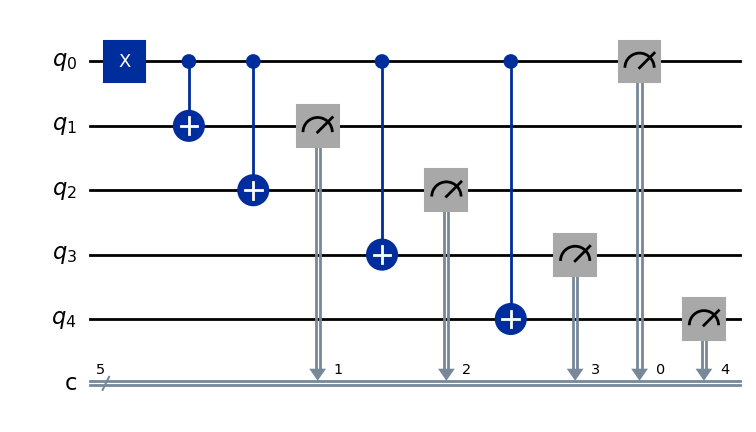

In [27]:
qc_rep = build_repetition_code_circuit(5, "1")
qc_rep.draw("mpl")

In [ ]:
from qiskit.visualization import plot_histogram

def test_repetition_code_ideal(
    distance: int,
    logical_state: str = "0",
    shots: int = 1024,
    display_hist: bool = False,
) -> bool:
    qc = build_repetition_code_circuit(distance, logical_state, inject_error_qubit=None)

    sim = AerSimulator()
    job = sim.run(qc, shots=shots)
    result = job.result()
    counts = result.get_counts()

    expected = logical_state * distance
    success_prob = counts.get(expected, 0) / shots

    print(f"\n--- Repetition code ideal test (d={distance}, logical={logical_state}) ---")
    print("Counts:", counts)
    print(f"Expected bitstring: {expected}")
    print(f"Success probability: {success_prob:.4f}")

    if display_hist:
        display(plot_histogram(counts))

    return success_prob == 1.0


In [29]:
for d in [3, 5, 7]:
    for b in ["0", "1"]:
        ok = test_repetition_code_ideal(distance=d, logical_state=b, shots=1024)
        print(f"d={d}, logical={b} -> {'OK' if ok else 'FAIL'}")



--- Repetition code ideal test (d=3, logical=0) ---
Counts: {'000': 1024}
Expected bitstring: 000
Success probability: 1.0000
d=3, logical=0 -> OK

--- Repetition code ideal test (d=3, logical=1) ---
Counts: {'111': 1024}
Expected bitstring: 111
Success probability: 1.0000
d=3, logical=1 -> OK

--- Repetition code ideal test (d=5, logical=0) ---
Counts: {'00000': 1024}
Expected bitstring: 00000
Success probability: 1.0000
d=5, logical=0 -> OK

--- Repetition code ideal test (d=5, logical=1) ---
Counts: {'11111': 1024}
Expected bitstring: 11111
Success probability: 1.0000
d=5, logical=1 -> OK

--- Repetition code ideal test (d=7, logical=0) ---
Counts: {'0000000': 1024}
Expected bitstring: 0000000
Success probability: 1.0000
d=7, logical=0 -> OK

--- Repetition code ideal test (d=7, logical=1) ---
Counts: {'1111111': 1024}
Expected bitstring: 1111111
Success probability: 1.0000
d=7, logical=1 -> OK


In [ ]:
def run_repetition_code_on_stim(
    qc: QuantumCircuit,
    distance: int,
    logical_state: str,
    p1: float = 0.0,
    p2: float = 0.0,
    shots: int = 20_000,
) -> float:
    stim_circuit = qiskit_to_stim_circuit_with_noise(qc, p1=p1, p2=p2)
    
    # Build measurement mapping
    meas_map = []
    meas_counter = 0
    clbit_index = {cb: idx for idx, cb in enumerate(qc.clbits)}
    
    for gate in qc:
        op_name = gate.operation.name.lower()
        if op_name == "measure":
            cbit = gate.clbits[0]
            c_idx = clbit_index[cbit]
            meas_map.append((meas_counter, c_idx))
            meas_counter += 1
    
    # Sample from Stim
    sampler = stim_circuit.compile_sampler()
    samples = sampler.sample(shots)
    
    # Decode with majority vote
    correct_count = 0
    expected_bit = int(logical_state)
    
    for shot in samples:
        # Reconstruct measurement bitstring
        cvals = [0] * distance
        for meas_idx, c_idx in meas_map:
            if c_idx < distance:
                cvals[c_idx] = int(shot[meas_idx])
        
        # Majority vote decoding
        ones_count = sum(cvals)
        decoded_bit = 1 if ones_count > distance // 2 else 0
        
        if decoded_bit == expected_bit:
            correct_count += 1
    
    fidelity = correct_count / shots
    return fidelity

In [ ]:
def analyze_fidelity_vs_space_time(
    string_lengths,
    distances,
    rounds: int = 10,
    p_phys_surface: float = 1e-2,
    shots_pL: int = 50_000,
    shots_algo: int = 20_000,
    circuit_type: str = "bv",  # "bv", "xor", "ghz", "simon", or "repetition"
):
    results = []
    
    circuit_name = {
        "bv": "BV", 
        "xor": "XOR_n", 
        "ghz": "GHZ", 
        "simon": "Simon",
        "repetition": "Repetition Code"
    }[circuit_type]

    for n in tqdm(string_lengths, desc="Circuit Sizes"):

        # 1) Build logical circuit based on type
        if circuit_type == "bv":
            secret = "1" * n 
            qc_seq = build_bv_circuit(secret)
            expected_outcome = secret
            
        elif circuit_type == "xor":
            xor_input = "1" * n 
            qc_seq = build_xor_n_circuit(xor_input)
            expected_outcome = xor_parity(xor_input)
            
        elif circuit_type == "ghz":
            qc_seq = build_ghz_circuit(n)
            expected_outcome = None
            
        elif circuit_type == "simon":
            secret = "1" + "01" * ((n-1)//2) + ("0" if n % 2 == 0 else "")
            secret = secret[:n]
            qc_seq = build_simon_circuit(n, secret)
            expected_outcome = secret
            
        elif circuit_type == "repetition":
            logical_state = "1"
            qc_seq = build_repetition_code_circuit(
                distance=n,
                logical_state=logical_state,
                inject_error_qubit=None
            )
            expected_outcome = logical_state
            code_distance_for_rep = n
            
        else:
            raise ValueError(f"Unknown circuit_type: {circuit_type}")

        # 2) Apply CAQR
        qc_caqr, iter_count, _ = apply_caqr(qc_seq)

        # 3) Scan code distances
        for d in tqdm(distances, desc=f"Distances (n={n})", leave=False):

            pL = estimate_pL_surface_code(
                distance=d,
                rounds=rounds,
                p_phys=p_phys_surface,
                shots=shots_pL,
            )

            p1 = pL
            p2 = 2 * pL

            # 3a) Compute fidelity for original circuit
            if circuit_type == "ghz":
                result_orig = run_ghz_on_stim(qc_seq, n, p1=p1, p2=p2, 
                                           shots=shots_algo)
                F_orig = result_orig['all_zeros_prob'] + result_orig['all_ones_prob']
                
            elif circuit_type == "simon":
                F_orig = run_simon_on_stim(qc_seq, expected_outcome, p1=p1, p2=p2,
                                          shots=shots_algo)
                
            elif circuit_type == "repetition":
                F_orig = run_repetition_code_on_stim(
                    qc_seq, code_distance_for_rep, expected_outcome, 
                    p1=p1, p2=p2, shots=shots_algo
                )
                
            else:  # BV or XOR
                F_orig = run_bv_on_stim(qc_seq, expected_outcome, p1=p1, p2=p2,
                                       shots=shots_algo)

            # 3b) Compute fidelity for CAQR circuit
            if circuit_type == "ghz":
                result_caqr = run_ghz_on_stim(qc_caqr, n, p1=p1, p2=p2,
                                            shots=shots_algo)
                F_caqr = result_caqr['all_zeros_prob'] + result_caqr['all_ones_prob']
                
            elif circuit_type == "simon":
                F_caqr = run_simon_on_stim(qc_caqr, expected_outcome, p1=p1, p2=p2,
                                          shots=shots_algo)
                
            elif circuit_type == "repetition":
                F_caqr = run_repetition_code_on_stim(
                    qc_caqr, code_distance_for_rep, expected_outcome,
                    p1=p1, p2=p2, shots=shots_algo
                )
                
            else:  # BV or XOR
                F_caqr = run_bv_on_stim(qc_caqr, expected_outcome, p1=p1, p2=p2,
                                       shots=shots_algo)

            # 3c) Approximate logical space–time volume
            V_orig = physical_space_time_volume(qc_seq, distance=d)
            V_caqr = physical_space_time_volume(qc_caqr, distance=d)

            results.append({
                "n": n,
                "d": d,
                "reuses": iter_count,
                "V_orig": V_orig,
                "V_caqr": V_caqr,
                "F_orig": F_orig,
                "F_caqr": F_caqr,
            })

    # 4) Plot fidelity vs space–time volume
    fig, ax = plt.subplots(figsize=(8, 6))

    V_orig_all = [r['V_orig'] for r in results]
    F_orig_all = [r['F_orig'] for r in results]
    V_caqr_all = [r['V_caqr'] for r in results]
    F_caqr_all = [r['F_caqr'] for r in results]

    orig_by_d = defaultdict(lambda: {'V': [], 'F': []})
    caqr_by_d = defaultdict(lambda: {'V': [], 'F': []})
    
    for r in results:
        d = r['d']
        orig_by_d[d]['V'].append(r['V_orig'])
        orig_by_d[d]['F'].append(r['F_orig'])
        caqr_by_d[d]['V'].append(r['V_caqr'])
        caqr_by_d[d]['F'].append(r['F_caqr'])
    
    V_o_avg = []
    F_o_avg = []
    V_c_avg = []
    F_c_avg = []
    distances_used = sorted(orig_by_d.keys())
    
    for d in distances_used:
        V_o_avg.append(np.mean(orig_by_d[d]['V']))
        F_o_avg.append(np.mean(orig_by_d[d]['F']))
        V_c_avg.append(np.mean(caqr_by_d[d]['V']))
        F_c_avg.append(np.mean(caqr_by_d[d]['F']))
    
    V_o_avg = np.array(V_o_avg)
    F_o_avg = np.array(F_o_avg)
    V_c_avg = np.array(V_c_avg)
    F_c_avg = np.array(F_c_avg)
    
    ax.set_xscale("log")

    ax.scatter(V_orig_all, F_orig_all, marker="o", s=30, alpha=0.3, color='blue', 
               label="Original (all)")
    ax.scatter(V_caqr_all, F_caqr_all, marker="s", s=30, alpha=0.3, color='orange', 
               label="CAQR (all)")
    
    # Fit logistic curves
    if len(V_o_avg) > 3:
        try:
            p0_o = [1.0 - F_o_avg.min(), 1.0, np.log10(np.median(V_o_avg)), F_o_avg.min()]
            popt_o, _ = curve_fit(logistic_model, V_o_avg, F_o_avg, p0=p0_o, maxfev=5000)
            
            V_o_fit = np.logspace(np.log10(V_o_avg.min()), np.log10(V_o_avg.max()), 100)
            F_o_fit = logistic_model(V_o_fit, *popt_o)
            ax.plot(V_o_fit, F_o_fit, "b-", color="navy", alpha=0.9, linewidth=3, label="Fit Orig")
        except:
            print("Warning: Could not fit original data")
            
    if len(V_c_avg) > 3:
        try:
            p0_c = [1.0 - F_c_avg.min(), 1.0, np.log10(np.median(V_c_avg)), F_c_avg.min()]
            popt_c, _ = curve_fit(logistic_model, V_c_avg, F_c_avg, p0=p0_c, maxfev=5000)
            
            V_c_fit = np.logspace(np.log10(V_c_avg.min()), np.log10(V_c_avg.max()), 100)
            F_c_fit = logistic_model(V_c_fit, *popt_c)
            ax.plot(V_c_fit, F_c_fit, color="crimson", linestyle="-", alpha=0.9, 
                   linewidth=3, label="Fit CAQR")
        except:
            print("Warning: Could not fit CAQR data")

    ax.set_xlabel("Physical space–time volume", fontsize=12)
    ax.set_ylabel("Fidelity", fontsize=12)
    ax.set_title(f"{circuit_name}: Fidelity vs space–time volume", fontsize=14)
    ax.set_ylim(0, 1.05)
    ax.grid(True, alpha=0.3)
    ax.legend()

    plt.tight_layout()
    plt.show()
    
    return results

In [32]:
# Run analysis for Repetition Code with CAQR applied
distances = [n for n in range(3, 21, 2)]
lengths = [n for n in range(3, 31, 4)]
rounds = 10
p_phys_surface = 1e-2
shots_pL = 50_000
shots_algo = 20_000

print("\n" + "=" * 90)
print("FIDELITY vs SPACE–TIME VOLUME – REPETITION CODE (WITH CAQR)")
print("=" * 90)

repetition_volume_results = analyze_fidelity_vs_space_time(
    string_lengths=lengths,
    distances=distances,
    rounds=rounds,
    p_phys_surface=p_phys_surface,
    shots_pL=shots_pL,
    shots_algo=shots_algo,
    circuit_type="repetition",
)


FIDELITY vs SPACE–TIME VOLUME – REPETITION CODE (WITH CAQR)


Circuit Sizes:   0%|          | 0/7 [00:00<?, ?it/s]

Distances (n=3):   0%|          | 0/9 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [33]:
from qiskit.converters import circuit_to_dag
import numpy as np

#one_beat is assumed to be all other gates
two_beat_gates = ['cx'] #we assume that the circuits are small enough that cnots do not require too much overhead
three_beat_gates = ['h']

def get_logical_circuit_time(qc: QuantumCircuit):
    """
    # TODO UPDATE THIS FUNCTION TO USE THE DAG SO DIFFERENT LENGTH OPS CAN STILL BE RAN AT THE SAME TIME




    we model the temporal circuit depth adhering to Table I in ... et al. with 0 replaced with 1
    we use a heuristic approximation of the depth of the circuit, in the sense that
    we assume qubits with different durations cannot be executed in parallel, which
    is a simplifying assumption in the model.

    we ignore preparation time at the beginning of the circuit, 
    but not after reset operations
    """
    one_beats = qc.depth(lambda op: op.name not in two_beat_gates and op.name not in three_beat_gates)
    two_beats = qc.depth(lambda op: op.name in two_beat_gates)
    three_beats = qc.depth(lambda op: op.name in three_beat_gates)
    return one_beats + 2 * two_beats + 3 * three_beats

def get_average_lifetimes(qc: QuantumCircuit):
    dag = circuit_to_dag(qc)
    all_lifetimes = []
    dynamic_lifetimes = [0] * qc.num_qubits
    measured_qubits = []

    for depth, layer in enumerate(dag.layers()):
        longest_time_op = 1
        
        for node in layer["graph"].op_nodes():
            #assume that a barrier cannot be at the same time as any other operation
            if node.name == 'barrier':
                longest_time_op = 0
                break
            elif node.name in two_beat_gates:
                longest_time_op = max(2, longest_time_op)
            elif node.name in three_beat_gates:
                longest_time_op = max(3, longest_time_op)

            if node.name == 'measure':
                for q in node.qargs:
                    index = qc.qubits.index(q)
                    #fixes the qubit lifetime so it will not be incremented later, unless there is a reset
                    measured_qubits.append(index)
                    dynamic_lifetimes[index] += 1 #measurement takes 1 time unit

            if node.name == 'reset':
                for q in node.qargs:
                    index = qc.qubits.index(q)
                    all_lifetimes.append(dynamic_lifetimes[index])
                    dynamic_lifetimes[index] = 0
                    try:
                        measured_qubits.remove(index)
                    except:
                        ValueError()
        for i in range(qc.num_qubits):
            #only increment non-measured qubits, as measured ones no longer count as living
            if i not in measured_qubits:
                dynamic_lifetimes[i] += longest_time_op
        
    all_lifetimes += list(filter(lambda x: x != 0, dynamic_lifetimes))
    return {'avg_lifetime': np.mean(all_lifetimes), 'max_lifetime': np.max(all_lifetimes), 'lifetimes': all_lifetimes}

In [34]:
qc_simon = build_simon_circuit(5, "11010")
stats = get_average_lifetimes(qc_simon)
print(f"Simon Circuit Lifetimes: {stats}")
qc_simon_caqr, _, _ = apply_caqr(qc_simon)
stats_caqr = get_average_lifetimes(qc_simon_caqr)
print(f"Simon CAQR Circuit Lifetimes: {stats_caqr}")

Simon Circuit Lifetimes: {'avg_lifetime': np.float64(12.0), 'max_lifetime': np.int64(14), 'lifetimes': [9, 14, 9, 9, 9, 14, 14, 14, 14, 14]}
Simon CAQR Circuit Lifetimes: {'avg_lifetime': np.float64(23.4), 'max_lifetime': np.int64(36), 'lifetimes': [5, 9, 9, 6, 10, 10, 36, 36, 36, 19, 31, 36, 36, 36, 36]}
